# **Fine-tuning Transformer Models Using PEFT (Parameter-Efficient Fine-Tuning) Techniques**

---

This notebook is part of a broader study on *Parameter-Efficient Fine-Tuning (PEFT)* methods. For a detailed explanation of the concepts and techniques covered here, check out:  
- **English article**: [Parameter-Efficient Fine-Tuning (PEFT) Methods](https://huggingface.co/blog/samuellimabraz/peft-methods)  
- **Portuguese article**: [Técnicas de Fine-Tuning Eficiente em LLMs](https://medium.com/me/stats/post/ffac60ac9d15)  
- **Experimentation analysis**: [Ajuste Fino de Modelos Transformers através de Técnicas PEFT](https://ainews.net.br/ajuste-fino-de-modelos-transformers-atraves-detecnicas-peft-parameter-efficient-fine-tuning/)  

Visit the links to explore the theoretical context and decisions behind this code! 🔍  

## **Transformer Architecture**

The Transformer architecture, introduced in 2017 in the paper ["Attention is All You Need"](https://arxiv.org/abs/1706.03762), revolutionized the field of natural language processing (NLP) and deep learning. Unlike recurrent and convolutional architectures, Transformers rely entirely on the attention mechanism, enabling more efficient parallelism and superior performance on sequence-based tasks.

### **Original Architecture**

The Transformer architecture is composed of two main components: the Encoder and the Decoder.
The Encoder is responsible for mapping an input into an intermediate representation, while the Decoder uses this intermediate representation to generate the output.

![Arquitetura Original](https://miro.medium.com/v2/resize:fit:1358/1*kf871smtQKXAf3dSYOlVPA.png)

#### **Attention Mechanism**
A key characteristic of Transformer models is that they are built with special layers called attention layers.
These layers instruct the model to focus specifically on certain words in the input sentence (and to pay less attention to others) when processing the representation of each word in its context.

The attention mechanism is central to the Transformer architecture and consists of three main components:

- **Query (Q)**: Represents the current input element that seeks to attend to other parts of the sequence.
- **Key (K)** and **Value (V)**: Represent the features of the sequence that will be compared to the Query.

Attention is computed as a dot product between Q and K, followed by Softmax normalization to obtain attention weights, which are then applied to the Values.

In the context of multi-head attention, this operation is performed multiple times in parallel, allowing the model to learn and capture different patterns of attention across various subspaces.

#### **Encoder Block**
The encoder receives an input and builds its internal representation (its features).
This means the model is optimized to understand and capture the meaning of the input.

Each Encoder Block consists of two main sub-layers:

- **Multi-Head Self-Attention**: Allows the model to attend to different parts of the input sequence simultaneously.
The attention layer is composed of multiple heads that perform attention operations in parallel. Their outputs are then concatenated and projected into a single representation.
- **Feed-Forward Neural Network**: Composed of two linear layers with a non-linear activation (ReLU) in between. The first layer expands the data dimensionality, while the second reduces it back to the original size.

Both sub-layers are wrapped with:

- **Layer Normalization** , to stabilize and accelerate training.
- **Layer Normalization** , to help preserve gradients and improve convergence during training.


#### **Decoder Block**
The decoder uses the representation generated by the encoder (features) along with other inputs to produce the target sequence. This means the model is optimized for output generation.

The Decoder is similar to the Encoder, but with a few key differences:

- **Masked Multi-Head Self-Attention**: Similar to the encoder’s attention mechanism, but includes a mask that prevents the current position from attending to future positions — essential for sequential generation tasks.
- **Multi-Head Attention**: Performs attention over the encoder’s output, allowing the decoder to focus on the most relevant parts of the input sequence.
- **Feed-Forward Neural Network**: Identical in structure to the one used in the encoder — two linear layers with a ReLU activation in between.

As in the encoder, each sub-layer in the decoder is wrapped with:

- **Layer Normalization** ,  to stabilize training.

- **Residual Connections** , to facilitate gradient flow and improve training efficiency.


### **Model Variations**

Each part of the architecture can be used independently, depending on the task:

- **Encoder-only models**: good for tasks that require understanding of the input, such as sentence classification and named entity recognition. These models are typically characterized as having "bidirectional" attention and are often called auto-encoding models.
  - [BERT](https://huggingface.co/transformers/model_doc/bert.html)
  - [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert)
  - [RoBERTa](https://huggingface.co/transformers/model_doc/roberta.html)
- **Decoder-only models**: good for generative tasks, such as text generation. At each step, for a given word, the attention layers can only access words positioned before it in the sentence. These models are typically called auto-regressive models.
  - [GPT](https://huggingface.co/docs/transformers/model_doc/openai-gpt)
  - [GPT-2](https://huggingface.co/docs/transformers/model_doc/gpt2)
- **Encoder-decoder models or sequence-to-sequence models**: good for generative tasks that require an input, such as summarization, translation, question answering, and generative responses
  - [BART](https://huggingface.co/docs/transformers/model_doc/bart)
  - [T5](https://huggingface.co/docs/transformers/model_doc/t5)


## **Fine-Tuning**

Transformers are large and complex models, and increasing their size and the amount of pre-training data is a common strategy to improve performance. However, training these models from scratch is highly costly in terms of time, computational resources, and even environmentally, due to energy consumption. Therefore, sharing pre-trained models has become essential, allowing the community to reduce costs and leverage efficiency gains.

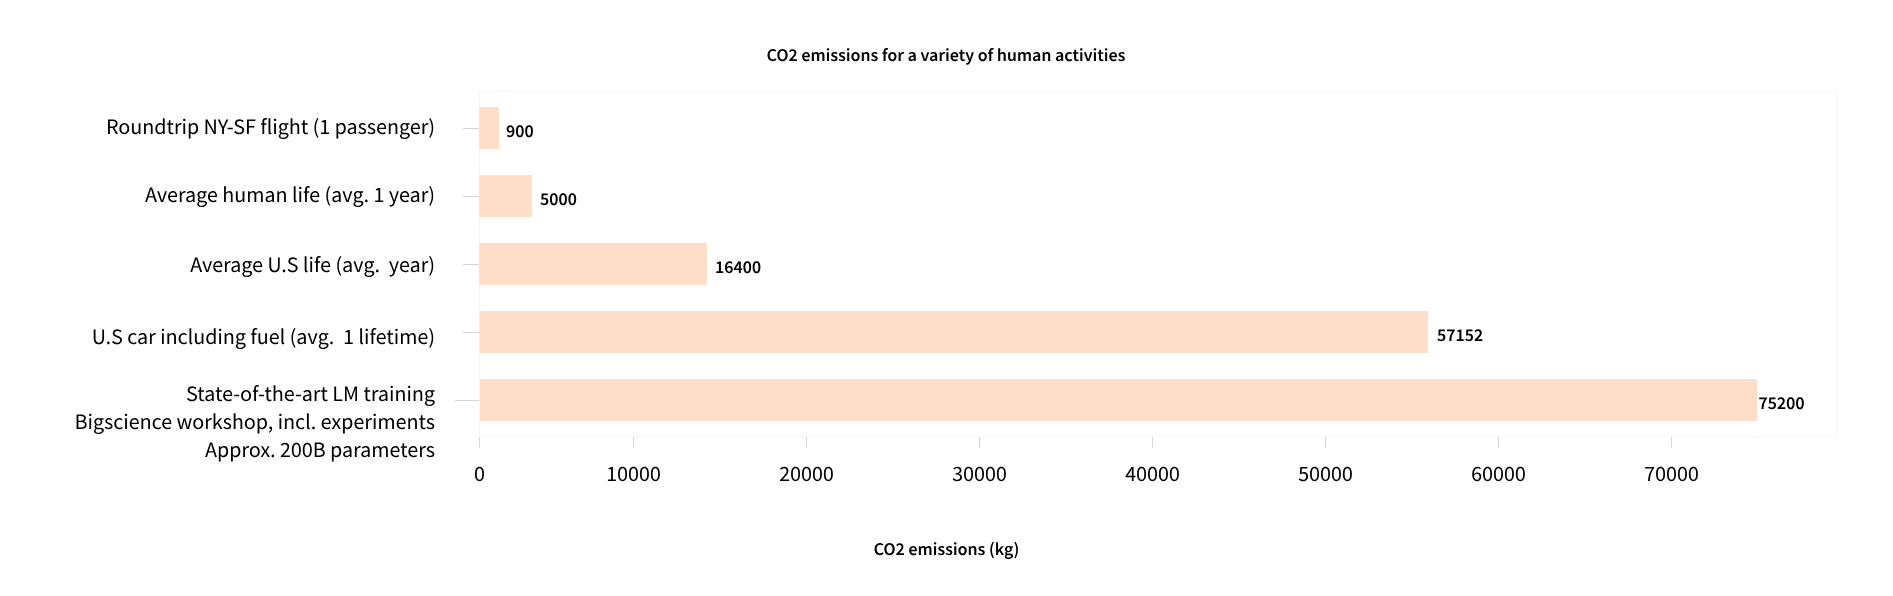

`Transfer Learning` is the technique that leverages pre-trained models on one task to be adapted to another specific task. In large language models (LLMs), such as GPT or BERT, this technique allows the knowledge acquired from large corpora to be reused and adjusted for specific tasks, such as text classification, machine translation, or question answering. This adaptation is done by fine-tuning the model in a supervised manner with new labeled data from the target task.

`Fine-Tuning` is the process of specializing a pre-trained model for a specific task. It adjusts the model's weights based on a smaller labeled dataset, while maintaining the general knowledge acquired during pre-training. This approach requires less data and resources, resulting in significant efficiency gains without compromising performance on the new task.

### Methods

Fine-tuning processes can be broadly categorized into two types: **Full Fine-Tuning** and **Parameter-Efficient Fine-Tuning (PEFT)**.

![Finetuning Methods](https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https://substack-post-media.s3.amazonaws.com/public/images/d9c855ba-814f-4f95-9b1b-c97a46eb2f42_1646x880.png)

#### **Full Fine-Tuning**

Training all parameters of a model for a specific task. One technique within this type of process is Instruction Tuning, which essentially uses a dataset with Prompt-Completion pairs. These can be questions and answers, or instructions and actions taken.

![FullFinetuning](https://th.bing.com/th/id/OIP.PLTzifVB7cEQEQBkG914mgAAAA?rs=1&pid=ImgDetMain)

Source: https://www.coursera.org/learn/generative-ai-with-llms/

The full fine-tuning process is highly effective in specializing LLMs. However, the fact that tuning occurs across all model parameters makes this process slow and expensive. The alternative developed was the PEFT processes.

#### **Parameter-Efficient Fine-Tuning (PEFT)**

Parameter-Efficient Fine-Tuning (PEFT) methods can be classified according to two main aspects: their conceptual structure (e.g., introducing new parameters or adjusting existing parameters) and their primary objective (minimizing memory footprint, storage efficiency, or reducing computational costs). These methods are divided into three major categories:

**Additive Methods**

Additive methods introduce new parameters into the base model, typically through small adapter layers or by adjusting a portion of the input embeddings (known as soft prompts). These methods are widely used and include:

* **Adapters**: Small dense (fully connected) networks that are inserted after specific transformer sublayers, enabling adaptation to new tasks without the need to train all model parameters.
* **Soft Prompts**: Fine adjustments applied directly to the model's input embeddings, facilitating adaptation to target tasks without modifying the model's internal parameters.

These methods are generally memory-efficient, as they reduce the size of gradients and optimizer states.

**Selective Methods**

Selective methods adjust only a fraction of the model's existing parameters. This can be done in different ways, such as:

* **Upper Layer Tuning**: Focusing on adjusting only the upper layers of the network, leaving the lower layers intact.
* **Specific Parameter Tuning**: Selective training of certain types of parameters, such as biases, while other parameters remain frozen.
* **Sparse Updates**: Selection of a specific subset of parameters to be trained. While promising, this approach can be computationally more expensive due to the need to identify the most relevant parameters.

Despite savings in terms of trained parameters, selective methods can have high computational costs, especially in sparse configurations.

**Reparameterization-Based Methods**

Reparameterization-based methods reduce the number of trainable parameters by using low-rank representations, exploiting the redundancy present in neural networks. Some of the main methods include:

* **LoRA (Low-Rank Adaptation)**: Uses low-rank matrix decomposition to represent weight updates, resulting in an efficient form of fine-tuning.
* **Intrinsic SAID**: Employs the Fastfood transform, a technique for representing low-rank updates in a computationally efficient manner.

These methods offer a significant reduction in the number of parameters to be trained, making them ideal for situations where storage efficiency and training time are critical.

**Additional Points**
* Additive Methods: While they introduce new parameters, they can be more efficient in terms of overall memory, reducing the amount of gradients and optimizer states that need to be stored.
* Selective Methods: While promising for reducing the number of trained parameters, they can be computationally intensive, particularly in cases of sparse updates.
* Hybrid Methods: Combinations of ideas from different categories are often explored to maximize performance, leveraging the best of each approach.

![PEFT Categories](https://assets-global.website-files.com/640f56f76d313bbe39631bfd/64ac796b64197e69fc87f670_iWe274ACYUm0_Q-aPmdQPWUSWZR4YnNs2gP7xxX2sCZh7TXPL5WWfOu4pEkJGBkNridVRNFMnkHlc3NjE9M-5SMlv9pksU1LZ_G7Jjb7OzPXNeqKpURkaGfWa5uyWL48sle16BUmXsGlTHOk8ui4xIA.png)

source: [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning" and the PEFT module](https://arxiv.org/abs/2303.15647)

# Experimentation: Fine-Tuning an LLM for Customer-Agent Dialogue Summarization

This experimentation involves the practice of fine-tuning methods on language models for the task of customer service conversation summarization, covering the entire machine learning cycle, from data preparation to hyperparameter tuning and evaluation.

## Installation and Configuration

We need the following 🤗 Hugging Face libraries:
* [transformers](https://huggingface.co/transformers/) contains an API for training models and many pre-trained models
* [tokenizers](https://huggingface.co/docs/tokenizers/python/latest/) is automatically installed with transformers and "tokenizes" our data (i.e., converts text into sequences of numbers)
* [datasets](https://huggingface.co/docs/datasets/) contains a rich source of data, allowing dataset extraction from the hub and processing functions.
* [peft](https://huggingface.co/docs/peft/main/en/index) contains PEFT (Parameter-Efficient Fine-Tuning) methods to efficiently adapt large pre-trained models to various downstream applications without full fine-tuning
* [bitsandbytes](https://huggingface.co/docs/transformers/quantization/bitsandbytes) provides simple ways to quantize a model to 8 and 4 bits.
* [huggingface-hub](https://huggingface.co/docs/hub/index) HuggingFace platform with models, datasets, and open-source applications, so we can share,

We also install `wandb` to automatically instrument our training.

In [ ]:
!pip install transformers accelerate datasets bitsandbytes einops wandb evaluate py7zr torch huggingface-hub git+https://github.com/huggingface/peft.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score bert_score openai azure-identity --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.3/191.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.4 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Wed Jan 21 05:23:52 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Import

Here we will import all the modules that will be used in the development

In [ ]:
from datasets import load_dataset, concatenate_datasets
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    pipeline
)
from peft import (
    LoraConfig,
    IA3Config,
    PeftModel,
    PeftConfig,
    AutoPeftModelForSeq2SeqLM,
    get_peft_model,
    TaskType,
    prepare_model_for_kbit_training
)
import torch
from huggingface_hub import login, notebook_login

import os
import shutil
import time
import evaluate
import requests
import pandas as pd
import numpy as np
from dataclasses import dataclass
import wandb
from tqdm import tqdm
from abc import ABC, abstractmethod
from random import randrange, sample
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Weights and Biases (W&B)

[Weights and Biases (W&B)](https://wandb.ai/site) is an instrumentation tool for machine learning model training that allows tracking experiments, visualizing real-time metrics, logging hyperparameters and results, and collaborating with other team members. It integrates with popular libraries such as PyTorch, TensorFlow, and Hugging Face, facilitating automatic model instrumentation and training data analysis.

The [W&B Sweeps](https://docs.wandb.ai/guides/sweeps) functionality enables automated hyperparameter searches, testing different combinations to optimize model performance. You can configure sweep parameters with search strategies such as grid search, random search, or Bayesian optimization. W&B coordinates the experiments, logs the results, and provides visual comparisons between different runs, helping to efficiently identify the best hyperparameter sets.

For more details, see the [W&B + HF Integration Documentation](https://docs.wandb.ai/integrations/huggingface).

### Hugging Face Hub

This example will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model version control service. To be able to push our model to the Hub, you need to register on Hugging Face. If you already have an account, you can skip this step. Once you have an account, we will use the *notebook_login* utility from the *huggingface_hub* package to log into our account and store our token (access key) on disk.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Dataset

This example uses the [TweetSumm](https://github.com/guyfe/Tweetsumm) dataset, which focuses on dialogue summarization, representing the rich domain of customer service conversations on Twitter.

TweetSumm consists of 1,100 dialogues reconstructed from Tweets appearing in the Kaggle ["Customer Support On Twitter"](http://www.kaggle.com/thoughtvector/customer-support-on-twitter) dataset, each accompanied by 3 extractive summaries and 3 abstractive summaries generated by human annotators.

We will use a formatted version of this dataset on Hugging Face: [Andyrasika/TweetSumm-tuned](https://huggingface.co/datasets/Andyrasika/TweetSumm-tuned)

Data Fields

- conversation: conversation text.
- summary: human-written summary of the conversation.
- text: instruction-formatted prompt containing the conversation and summary.

Data Split

- train: 879 examples.
- val: 110 examples.
- test: 110 examples.

In [ ]:
{
  "conversation": "user: Do Apple updates always delete your recent contacts? I’ve easily lost over 50 contacts in a day. Thanks Oh and my battery sucks after the update as usual too. I’m sure that has nothing to do with the update, though. Nothing at all. agent: We can help with your missing contacts and battery. Has the device been restarted? Do you use iCloud for syncing contacts? user: Yes and yes. agent: Have you tried navigating to Settings &gt; [your name] &gt; iCloud and checking to ensure the contacts toggle is on? user: Yes. agent: Thanks for the screenshot and checking. Please DM us and we'll further review this for you.",
  "summary": "The customer is complaining that they have lost more than 50 contacts and battery also sucks after the update. The agent asked to dm them for further review on that issue.",
}

{'conversation': "user: Do Apple updates always delete your recent contacts? I’ve easily lost over 50 contacts in a day. Thanks Oh and my battery sucks after the update as usual too. I’m sure that has nothing to do with the update, though. Nothing at all. agent: We can help with your missing contacts and battery. Has the device been restarted? Do you use iCloud for syncing contacts? user: Yes and yes. agent: Have you tried navigating to Settings &gt; [your name] &gt; iCloud and checking to ensure the contacts toggle is on? user: Yes. agent: Thanks for the screenshot and checking. Please DM us and we'll further review this for you.",
 'summary': 'The customer is complaining that they have lost more than 50 contacts and battery also sucks after the update. The agent asked to dm them for further review on that issue.'}

In [ ]:
dataset_id = "Andyrasika/TweetSumm-tuned"

In [ ]:
# Load dataset from the hub
dataset = load_dataset(dataset_id, trust_remote_code=True)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Andyrasika/TweetSumm-tuned' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
ERROR:datasets.load:`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Andyrasika/TweetSumm-tuned' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error pers

README.md:   0%|          | 0.00/731 [00:00<?, ?B/s]

data/train-00000-of-00001-cf5872afd4ce2e(…):   0%|          | 0.00/1.26M [00:00<?, ?B/s]

data/validation-00000-of-00001-a80b0e36d(…):   0%|          | 0.00/163k [00:00<?, ?B/s]

data/test-00000-of-00001-4b19574d8fc3e03(…):   0%|          | 0.00/177k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/879 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/110 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/110 [00:00<?, ? examples/s]

Train dataset size: 879
Test dataset size: 110


In [ ]:
dataset['train'] = dataset['train'].rename_column('conversation', 'dialogue')
dataset['validation'] = dataset['validation'].rename_column('conversation', 'dialogue')
dataset['test'] = dataset['test'].rename_column('conversation', 'dialogue')

In [ ]:
sample_example = dataset['train'][randrange(len(dataset["train"]))]
print(f"dialogue: \n{sample_example['dialogue']}\n---------------")
print(f"summary: \n{sample_example['summary']}\n---------------")

dialogue: 
user: Also, Adobe Acrobat Pro is just as shitty and crash-prone as I remember it.
agent: Hi, how can we help you? Which issue are you having with your Adobe software? Can you provide details for your issue?
user: "Fill and Sign" chooses inconsistent decimal font sizes that I have to fix manually, and crashes every few minutes. Preview's Annotate is much simpler and faster and free.
agent: Hi, does this happen with all PDF forms that you using for "Fill and Sign"? Have you updated the app yet?
user: Yes and yes. + the permissions on all my PDFs are now screwed up - I can't open them in Preview anymore, only on Reader.
agent: Hi Sandra, I would suggest to reinstall the Adobe Reader app to see if this helps the issue. Please post this issue on our forums too.  Sandra, here is a link to our forums to post the issue to.
user: Uninstalling Reader and rebooting worked to resolve the file permissions problem.
agent: Hi Sanda, good to hear that. Thanks for the update. Please let us k

## Tokenizer

To train a neural network, we need to convert our inputs into numbers:
* the tokenizer splits a sequence of characters into tokens, i.e., subsequences (such as words, characters, subwords...)
* each unique token is mapped to a unique integer

There are many [types of tokenizers](https://huggingface.co/transformers/tokenizer_summary.html). 🤗 Transformers can automatically select the correct `Tokenizer` associated with a specific model.

In [ ]:
model_id = "google-t5/t5-base"

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True, use_fast=True)

#setting padding instructions for tokenizer
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
sample_input = dataset['train'][randrange(len(dataset["train"]))]["dialogue"]
print(sample_input)
tokenizer(sample_input)

user: can you help? DL 121 from LGA diverted to JFK. No update from staff. Late for meetings. Can you give us an update please? Nothing Solid support guys...
agent: Hello, Hamish! I am sorry about the diversion due to maintenance. Please accept my apology for any inconvenience that this has caused. *TCC
user: Your staff at the gate can’t board us because the seat map won’t match. Surely this has happened before? Get it together. And a stock apology doesn’t cut it. We want a full refund. Have missed two meetings. You boarded us on a plane with a known issue. Who do I speak to about the refund? I guess you only reply to the easy questions and pat yourself on the back Still stranded at JFKwithout answers. 4:20 delay now.
agent: I can offer you a refund on the flight. Shall I cancel your reservation and process a refund for both passengers? *TCC
user: Are you joking? We’re waiting to board for the second time, we do not want to cancel, we want a refund.
agent: We cannot offer a refund on a

{'input_ids': [1139, 10, 54, 25, 199, 58, 3, 10013, 3, 22011, 45, 301, 6302, 12355, 1054, 12, 446, 371, 439, 5, 465, 2270, 45, 871, 5, 13294, 21, 4677, 5, 1072, 25, 428, 178, 46, 2270, 754, 58, 9428, 12974, 380, 3413, 233, 3102, 10, 8774, 6, 5845, 1273, 55, 27, 183, 8032, 81, 8, 1227, 8674, 788, 12, 2453, 5, 863, 1845, 82, 30430, 21, 136, 25741, 24, 48, 65, 2953, 5, 1429, 3838, 254, 1139, 10, 696, 871, 44, 8, 10530, 54, 22, 17, 1476, 178, 250, 8, 3143, 2828, 751, 22, 17, 1588, 5, 3, 28186, 48, 65, 2817, 274, 58, 1609, 34, 544, 5, 275, 3, 9, 1519, 30430, 744, 22, 17, 1340, 34, 5, 101, 241, 3, 9, 423, 7147, 5, 2114, 4785, 192, 4677, 5, 148, 1476, 15, 26, 178, 30, 3, 9, 6112, 28, 3, 9, 801, 962, 5, 2645, 103, 27, 2516, 12, 81, 8, 7147, 58, 27, 3382, 25, 163, 8776, 12, 8, 514, 746, 11, 6234, 909, 30, 8, 223, 4886, 3, 12797, 15, 26, 44, 446, 371, 439, 23016, 4269, 5, 314, 10, 1755, 7230, 230, 5, 3102, 10, 27, 54, 462, 25, 3, 9, 7147, 30, 8, 3777, 5, 3926, 195, 27, 9179, 39, 13019, 11, 433, 

Abstractive Summarization is a text2text generation task. This means that our model will take a text as input and generate a summary as output. To do this, we want to understand how long our input and output will be so we can batch our data efficiently.

In [ ]:
# The maximum total input sequence length after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded.
tokenized_inputs = concatenate_datasets([dataset["train"], dataset["test"]]).map(lambda x: tokenizer(x["dialogue"], truncation=True), batched=True, remove_columns=["dialogue", "summary"])
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])
print(f"Max source length: {max_source_length}")

# The maximum total sequence length for target text after tokenization.
# Sequences longer than this will be truncated, sequences shorter will be padded."
tokenized_targets = concatenate_datasets([dataset["train"], dataset["test"]]).map(lambda x: tokenizer(x["summary"], truncation=True), batched=True, remove_columns=["dialogue", "summary"])
target_lengths = [len(x) for x in tokenized_targets["input_ids"]]
max_target_length = max(target_lengths)
min_target_length = min(target_lengths)
avg_target_length = sum(target_lengths) / len(target_lengths)
print(f"Max target length: {max_target_length}")
print(f"Min target length: {min_target_length}")
print(f"Avg target length: {avg_target_length:.2f}")

Map:   0%|          | 0/989 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Max source length: 792


Map:   0%|          | 0/989 [00:00<?, ? examples/s]

Max target length: 121
Min target length: 17
Avg target length: 41.93


In [ ]:
def tokenize_function(examples, padding="max_length", prefix="summarize: "):
    # remove pairs where at least one record is None
    inputs, targets = [], []
    text_column, summary_column = "dialogue", "summary"
    for i in range(len(examples[text_column])):
        if examples[text_column][i] and examples[summary_column][i]:
            inputs.append(examples[text_column][i])
            targets.append(examples[summary_column][i])

    inputs = [prefix + inp for inp in inputs]

    # tokenize inputs
    model_inputs = tokenizer(inputs, padding=padding, max_length=max_source_length, truncation=True, return_tensors="pt")
    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=targets, padding=padding, max_length=max_target_length, truncation=True, return_tensors="pt")

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
def get_tokenizer_dataset(dataset, max_samples=None):
    if max_samples:
        data = dataset.select(min(len(dataset), max_samples))
    data = dataset.map(
                tokenize_function,
                batched=True,
                remove_columns=dataset.column_names,
            )
    return data

In [ ]:
train_dataset = get_tokenizer_dataset(dataset["train"])
test_dataset = get_tokenizer_dataset(dataset["test"])
eval_dataset = get_tokenizer_dataset(dataset["validation"])

Map:   0%|          | 0/879 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

Map:   0%|          | 0/110 [00:00<?, ? examples/s]

In [ ]:
print(f"Shapes of the datasets:")
print(f"Training: {train_dataset.shape}")
print(f"Validation: {eval_dataset.shape}")
print(f"Test: {test_dataset.shape}")

print(train_dataset)

Shapes of the datasets:
Training: (879, 3)
Validation: (110, 3)
Test: (110, 3)
Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 879
})


## Zero-Shot Inference

Testing the model with zero-shot inference. We will test the base model and visualize its ability to generate the summary.

In [ ]:
# load model from the hub
original_model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
def get_number_of_trainable_model_parameters(model, show=True):
    all_model_params = sum(param.numel() for param in model.parameters())
    trainable_model_params = filter(lambda p: p.requires_grad, model.parameters())
    trainable_model_params = sum([np.prod(p.size()) for p in trainable_model_params])
    if show:
        print(f"trainable model parameters: {trainable_model_params:,}")
        print(f"all model parameters: {all_model_params:,}")
        print(f"percentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%")

    return int(all_model_params), int(trainable_model_params)

get_number_of_trainable_model_parameters(original_model)

trainable model parameters: 222,903,552
all model parameters: 222,903,552
percentage of trainable model parameters: 100.00%


(222903552, 222903552)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
original_model.to(device)
original_model.device

device(type='cuda', index=0)

In [ ]:
print(original_model.get_memory_footprint())

891614208


In [ ]:
def generate_text(model, prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    outputs = model.generate(**inputs, max_new_tokens=max_target_length)
    output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return output

In [ ]:
index = randrange(0, len(dataset["test"]))

dialogue = dataset['test'][index]['dialogue']
summary = dataset['test'][index]['summary']

prompt = f"""summarize: {dialogue}"""

output = generate_text(original_model, prompt)

dash_line = '-'.join('' for x in range(100))
print(dash_line)
print(f'PROMPT DE ENTRADA:\n{prompt}')
print(dash_line)
print(f'SUMÁRIO HUMANO:\n{summary}\n')
print(dash_line)
print(f'GERADO PELO MODELO - ZERO SHOT:\n{output}')

---------------------------------------------------------------------------------------------------
PROMPT DE ENTRADA:
summarize: user: Flight status via your website seems not to be working? Is that the case?
agent: Joan, we are unaware of any current issues. If you continue to experience issues, please contact Online Customer Support Desk at 888-750-3284. They can assist you with your online transaction. *ACJ
user: OK but website is where I turn to simply check flight status. Seems odd it is not working. Am picking up Delta passengers and use the website to check flight status.
agent: Hi. What Delta Flight are you trying to track status for? *TMA
user: Thx, I utilized the airport website and located arrival info there. Thanks
agent: I just went to the website on my personal tablet, and the website is pulling up any Delta Flight that I type in. *TMA Ok. Have a great day! ✈ #HappyHolidays 🎄 *TMA

------------------------------------------------------------------------------------------

You can see that the model struggles to summarize the dialogue compared to the human-made summary, but it extracts some important information from the text that indicates the model can be fine-tuned for the task at hand.

## **Evaluation**

Here we will define the model evaluation methods, whether quantitatively, with numerical and exact metrics, or qualitatively, by visualizing and judging the response.

### Analysis Quantitative

#### ROUGE

[ROUGE](https://aclanthology.org/W04-1013/) (Recall-Oriented Understudy for Gisting Evaluation) is a widely used metric for evaluating the quality of automatically generated summaries, measuring the overlap of words or phrases between the generated text and a reference. It is especially prevalent in the evaluation of summarization tasks. ROUGE examines various sets of words called `n-grams`. The main variants include:

* ROUGE-1: Measures the overlap of unigrams (single words) between the generated summary and the reference.
* ROUGE-2: Evaluates the overlap of bigrams (word pairs) between the summaries.
* ROUGE-L: Based on the longest common subsequence (Longest Common Subsequence - LCS), capturing how well the model maintains the structure and order of essential text elements.
* ROUGE-Lsum: Similar to ROUGE-L, but is applied at the sentence level and aggregates all results into a final score.

![ROUGE-L](https://miro.medium.com/max/1400/1*E9NapTGfUSpMr5sWKEijVg.png)

source: [The Ultimate Performance Metric in NLP](https://towardsdatascience.com/the-ultimate-performance-metric-in-nlp-111df6c64460)

In [ ]:
rouge = evaluate.load("rouge")

def compute_rouge(model_summaries, human_baseline_summaries):
    return rouge.compute(
        predictions=model_summaries,
        references=human_baseline_summaries[0:len(model_summaries)],
        use_aggregator=True,
        use_stemmer=True,
    )

In [ ]:
rouge

EvaluationModule(name: "rouge", module_type: "metric", features: [{'predictions': Value('string'), 'references': List(Value('string'))}, {'predictions': Value('string'), 'references': Value('string')}], usage: """
Calculates average rouge scores for a list of hypotheses and references
Args:
    predictions: list of predictions to score. Each prediction
        should be a string with tokens separated by spaces.
    references: list of reference for each prediction. Each
        reference should be a string with tokens separated by spaces.
    rouge_types: A list of rouge types to calculate.
        Valid names:
        `"rouge{n}"` (e.g. `"rouge1"`, `"rouge2"`) where: {n} is the n-gram based scoring,
        `"rougeL"`: Longest common subsequence based scoring.
        `"rougeLsum"`: rougeLsum splits text using `"
"`.
        See details in https://github.com/huggingface/datasets/issues/617
    use_stemmer: Bool indicating whether Porter stemmer should be used to strip word suffixes.
 

Although these metrics offer a quantitative way to compare summaries, they do not always capture fluency, coherence, or semantic accuracy, which are important characteristics in summaries generated by advanced LLMs. Models that generate accurate summaries but with a different structure from the reference text may be unfairly penalized by metrics like ROUGE, which rely on exact word matching. This limitation becomes more evident as LLMs produce increasingly articulate outputs that still convey the correct informative essence.

#### BERTScore

[BERTScore](https://huggingface.co/spaces/evaluate-metric/bertscore) brings a more advanced approach to text evaluation, using embeddings generated by models like BERT to measure semantic and contextual similarity between sentences. Instead of comparing only n-grams like traditional metrics, BERTScore analyzes the `embeddings` of each word in the sentences, allowing it to capture nuances of meaning and context that other metrics may not perceive. This makes it especially useful for evaluating the quality of texts generated by models that produce fluent and meaningful language, but without exact word-for-word correspondence.

In [ ]:
bertscore = evaluate.load("bertscore")

def compute_bertscore(model_summaries, human_baseline_summaries):
    return bertscore.compute(
        predictions=model_summaries,
        references=human_baseline_summaries[0:len(model_summaries)],
        lang="en"
    )

In [ ]:
bertscore

EvaluationModule(name: "bert_score", module_type: "metric", features: [{'predictions': Value('string'), 'references': List(Value('string'))}, {'predictions': Value('string'), 'references': Value('string')}], usage: """
BERTScore Metrics with the hashcode from a source against one or more references.

Args:
    predictions (list of str): Prediction/candidate sentences.
    references (list of str or list of list of str): Reference sentences.
    lang (str): Language of the sentences; required (e.g. 'en').
    model_type (str): Bert specification, default using the suggested
        model for the target language; has to specify at least one of
        `model_type` or `lang`.
    num_layers (int): The layer of representation to use,
        default using the number of layers tuned on WMT16 correlation data.
    verbose (bool): Turn on intermediate status update.
    idf (bool or dict): Use idf weighting; can also be a precomputed idf_dict.
    device (str): On which the contextual embeddi

#### G-Eval GPT-4

Inspired by the [`G-Eval`](https://arxiv.org/abs/2303.16634) framework that evaluates the quality of generated text using large language models. Unlike metrics like `ROUGE` or `BERTScore` that rely on comparison with reference summaries, the `gpt-4`-based evaluator assesses the quality of generated content based solely on the input prompt and text, without any ground truth reference. This makes it applicable to new datasets and tasks where human references are scarce or unavailable.

Here is an overview of this method:

1. We define four distinct criteria:
    1. **Relevance**: evaluates whether the summary includes only important information and excludes redundancies.
    2. **Coherence**: assesses the logical flow and organization of the summary.
    3. **Consistency**: checks if the summary aligns with the facts in the source document.
    4. **Fluency**: evaluates the grammar and readability of the summary.
2. We create prompts for each of these criteria, taking the original document and summary as inputs, and guiding the model to generate a numerical score from 1 to 5 for each criterion.
3. We generate scores from gpt-4 with the defined prompts, comparing them across summaries.

In this demonstration, we are using a direct scoring function where gpt-4 generates a discrete score (1-5) for each metric. Normalizing the scores and taking a weighted sum can result in more robust and continuous scores that better reflect the quality and diversity of summaries.

In [ ]:
import google.generativeai as genai
from google.colab import userdata
import os

# Configure the Generative AI client with your API key
# Make sure you have added your Google API key to Colab secrets with the name 'GOOGLE_API_KEY'
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize the Gemini model for evaluation
# You can choose a different Gemini model if needed, e.g., 'gemini-1.5-pro-latest'
gemini_model = genai.GenerativeModel('gemini-2.5-flash')

print("Gemini client initialized successfully.")

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)


Gemini client initialized successfully.


In [ ]:
# Evaluation prompt template based on G-Eval
EVALUATION_PROMPT_TEMPLATE = """
You will be given one summary written for an dialogue messages. Your task is to rate the summary on one metric.
Please make sure you read and understand these instructions very carefully.
Please keep this document open while reviewing, and refer to it as needed.

Evaluation Criteria:

{criteria}

Evaluation Steps:

{steps}

Example:

Source Text:

{document}

Summary:

{summary}

Evaluation Form (scores ONLY):

- {metric_name}
"""

# Metric 1: Relevance

RELEVANCY_SCORE_CRITERIA = """
Relevance(1-5) - selection of important content from the source. \
The summary should include only important information from the source document. \
Annotators were instructed to penalize summaries which contained redundancies and excess information.
"""

RELEVANCY_SCORE_STEPS = """
1. Read the summary and the source document carefully.
2. Compare the summary to the source document and identify the main points of the conversation.
3. Assess how well the summary covers the main points of the dialogue, and how much irrelevant or redundant information it contains.
4. Assign a relevance score from 1 to 5.
"""

# Metric 2: Coherence

COHERENCE_SCORE_CRITERIA = """
Coherence(1-5) - the collective quality of all sentences. \
We align this dimension with the DUC quality question of structure and coherence \
whereby "the summary should be well-structured and well-organized. \
The summary should not just be a heap of related information, but should build from sentence to a\
coherent body of information about a topic."
"""

COHERENCE_SCORE_STEPS = """
1. Read the conversation carefully and identify the main topic and key points.
2. Read the summary and compare it to the dialogue. Check if the summary covers the main topic and key points of the article,
and if it presents them in a clear and logical order.
3. Assign a score for coherence on a scale of 1 to 5, where 1 is the lowest and 5 is the highest based on the Evaluation Criteria.
"""

# Metric 3: Consistency

CONSISTENCY_SCORE_CRITERIA = """
Consistency(1-5) - the factual alignment between the summary and the summarized source. \
A factually consistent summary contains only statements that are entailed by the source document. \
Annotators were also asked to penalize summaries that contained hallucinated facts.
"""

CONSISTENCY_SCORE_STEPS = """
1. Read the conversation carefully and identify the main facts and details it presents.
2. Read the summary and compare it to the conversation. Check if the summary contains any factual errors that are not supported by the dialogue.
3. Assign a score for consistency based on the Evaluation Criteria.
"""

# Metric 4: Fluency

FLUENCY_SCORE_CRITERIA = """
Fluency(1-3): the quality of the summary in terms of grammar, spelling, punctuation, word choice, and sentence structure.
1: Poor. The summary has many errors that make it hard to understand or sound unnatural.
2: Fair. The summary has some errors that affect the clarity or smoothness of the text, but the main points are still comprehensible.
3: Good. The summary has few or no errors and is easy to read and follow.
"""

FLUENCY_SCORE_STEPS = """
Read the summary and evaluate its fluency based on the given criteria. Assign a fluency score from 1 to 3.
"""

def get_geval_score(
    criteria: str, steps: str, document: str, summary: str, metric_name: str
):
    prompt = EVALUATION_PROMPT_TEMPLATE.format(
        criteria=criteria,
        steps=steps,
        metric_name=metric_name,
        document=document,
        summary=summary,
    )

    # Use the globally defined gemini_model from cell g3Ew6x1XkeCX
    response = gemini_model.generate_content(
        prompt,
        generation_config={
            "temperature": 0,
            "max_output_tokens": 5,
            "top_p": 1,
        },
    )

    # Gemini API returns the content in 'text'
    return response.text


# Função para computar as pontuações GEval
def compute_geval(dialogues, summaries):
    evaluation_metrics = {
        "Relevance": ("RELEVANCY_SCORE_CRITERIA", "RELEVANCY_SCORE_STEPS"),
        "Coherence": ("COHERENCE_SCORE_CRITERIA", "COHERENCE_SCORE_STEPS"),
        "Consistency": ("CONSISTENCY_SCORE_CRITERIA", "CONSISTENCY_SCORE_STEPS"),
        "Fluency": ("FLUENCY_SCORE_CRITERIA", "FLUENCY_SCORE_STEPS"),
    }

    geval_scores = {metric: [] for metric in evaluation_metrics.keys()}

    for dialogue, summary in zip(dialogues, summaries):
        for metric_name, (criteria, steps) in evaluation_metrics.items():
            # Use eval() to get the actual criteria and steps string content
            criteria_content = eval(criteria)
            steps_content = eval(steps)
            result = get_geval_score(criteria_content, steps_content, dialogue, summary, metric_name)
            # Assuming the Gemini model will return a single digit score as text
            try:
                geval_scores[metric_name].append(int(result.strip()[0]))
            except (ValueError, IndexError) as e:
                print(f"Could not parse score for {metric_name}. Response: '{result}', Error: {e}")
                # Handle cases where the model might not return a clean score
                geval_scores[metric_name].append(0) # or some other default/error value

    # Média das pontuações para cada métrica
    avg_geval_scores = {metric: sum(scores)/len(scores) for metric, scores in geval_scores.items() if scores}
    return avg_geval_scores

#### Compute Metrics

We want to evaluate our model during training. The `Trainer` supports evaluation during training by providing a compute_metrics. We will implement the function by computing Rouge and BertScore for the evaluation phase. G-Eval will not be used during training as it increases latency.

In [ ]:
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100s used for padding as we can't decode them
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = compute_rouge(decoded_preds, decoded_labels)
    # result = {key: 100 * value for key, value in result.items()}

    # Calculates the length of each prediction by counting the non-padding tokens.
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    # Computes the mean length of the predictions and adds it to the result dictionary under the key "gen_len".
    result["gen_len"] = np.mean(prediction_lens)

    # Computes the bertscore and separate the metrics
    bertscore = compute_bertscore(decoded_preds, decoded_labels)
    result["f1"] = np.mean(bertscore["f1"])
    result["precision"] = np.mean(bertscore["precision"])
    result["recall"] = np.mean(bertscore["recall"])

    # Rounds each value in the result dictionary to 4 decimal places for cleaner output, and returns the result.
    return {k: round(v, 4) for k, v in result.items()}

def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak.
    This is a workaround to avoid storing too many tensors that are not needed.
    """
    pred_ids = torch.argmax(logits[0], dim=-1)
    return pred_ids, labels

#### Report

Here are some helper functions to evaluate and compare the final models resulting from training, calculating and formatting all the described metrics and generating an absolute percentage comparison between them. This way we can generate a final metrics report for multiple models.

In [ ]:
def extract_metrics(rouge_results, bertscore_results, geval_results):
    metrics = {
        "rouge1": rouge_results['rouge1'],
        "rouge2": rouge_results['rouge2'],
        "rougeL": rouge_results['rougeL'],
        "rougeLsum": rouge_results.get('rougeLsum', {}),
        "precision": np.mean(bertscore_results['precision']),
        "recall": np.mean(bertscore_results['recall']),
        "f1": np.mean(bertscore_results['f1']),
        "relevance": geval_results["Relevance"],
        "coherence": geval_results["Coherence"],
        "consistency": geval_results["Consistency"],
        "fluency": geval_results["Fluency"],
    }
    return metrics

def evaluation(dialogues, human_baseline_summaries, model, tokenizer):
    model_summaries = []

    for dialogue in dialogues:
        # Gera o sumário usando o modelo
        model_summaries.append(generate_text(model, f"summarize: {dialogue}"))

    # Calcula as métricas
    rouge_results = compute_rouge(model_summaries, human_baseline_summaries)
    bertscore_results = compute_bertscore(model_summaries, human_baseline_summaries)
    geval_results = compute_geval(dialogues, model_summaries)


    # Organiza os resultados em um DataFrame
    zipped_summaries = list(zip(human_baseline_summaries, model_summaries))
    df = pd.DataFrame(zipped_summaries, columns=['human_baseline_summaries', 'model_summaries'])
    metrics_results = extract_metrics(rouge_results, bertscore_results, geval_results)

    return df, metrics_results

In [ ]:
# Função para verificar se o arquivo JSON existe
def check_json_exists(url):
    response = requests.head(url)
    return response.status_code == 200

def download_model_metrics(url):
    response = requests.get(url)
    response.raise_for_status()
    return response.json()

def default_metrics():
    # Retorna métricas padrão caso ocorra algum erro
    return {
            'all_params': None,
            "trainable_params": None,
            'trainable_params_percent': None,
            'epoch': None,
            'train_runtime' : None,
            'memory_footprint': None,
        }

def format_memory_footprint(memory_footprint):
    if memory_footprint is None:
        return None
    # Converte de bytes para gigabytes com no máximo 2 casas decimais
    return round(memory_footprint / (1024 ** 3), 6)

def fetch_or_calculate_metrics(url, model):
    # Tenta baixar métricas do JSON ou calcular diretamente
    if check_json_exists(url):
        json_data = download_model_metrics(url)
        return {
            'all_params': json_data.get('all_params', None),
            "trainable_params": json_data.get('trainable_params', None),
            'trainable_params_percent': json_data.get('trainable_params_percent', None),
            'epoch': json_data.get('epoch', None),
            'train_runtime' : json_data.get('train_runtime', None),
            'memory_footprint': format_memory_footprint(json_data.get('memory_footprint', None)),
        }
    else:
        # Se o JSON não existir, calcula as métricas diretamente
        return calculate_model_metrics(model)

def calculate_model_metrics(model):
    try:
        all_params, trainable_params = get_number_of_trainable_model_parameters(model, show=False)
        memory_footprint = model.get_memory_footprint()
        trainable_percent = 100 * trainable_params / all_params

        return {
            'all_params': all_params,
            "trainable_params": trainable_params,
            'trainable_params_percent': trainable_percent,
            'epoch': None,
            'train_runtime' : None,
            'memory_footprint': format_memory_footprint(memory_footprint),
        }
    except Exception as e:
        print(f"Erro ao calcular as métricas diretamente: {e}")
        return default_metrics()

In [ ]:
def build_metrics_dataframe(dialogues, human_baseline_summaries, models, tokenizer):
    model_results = {}

    # Avalia cada modelo na lista
    for model_name, model in tqdm(models.items(), desc="Evaluating models"):
        df, results = evaluation(dialogues, human_baseline_summaries, model, tokenizer)
        # Baixa os dados JSON do Hugging Face
        url = f"https://huggingface.co/samuellimabraz/{model_name}/resolve/main/train_results.json"
        try:
            results.update(fetch_or_calculate_metrics(url, model))
        except Exception as e:
            print(f"Erro ao processar métricas para {model_name}: {e}")
            results.update(default_metrics())

        model_results[model_name] = results

    # Cria o DataFrame com os resultados
    df_metrics = pd.DataFrame(model_results)

    # Define formatação personalizada para cada coluna
    format_dict = {
        'rouge1': '{:.6f}',
        'rouge2': '{:.6f}',
        'rougeL': '{:.6f}',
        'rougeLsum': '{:.6f}',
        'precision': '{:.6f}',
        'recall': '{:.6f}',
        'f1': '{:.6f}',
        'relevance': '{:.1f}',
        'coherence': '{:.1f}',
        'consistency': '{:.1f}',
        'fluency': '{:.1f}',
        'all_params': '{:.0f}',
        'trainable_params': '{:.0f}',
        'trainable_params_percent': '{:.6f}',
        'epoch': '{:.0f}',
        'train_runtime': '{:.2f}',
        'memory_footprint': '{:.6f}'
    }

    # Aplica o formato definido em cada coluna
    styled_df_metrics = df_metrics.style.format(format_dict)

    # Função para destacar os valores máximos no DataFrame
    def highlight_max(s):
        is_max = s == s.max()
        return [
            "background-color: green" if v else "background-color: black"
            for v in is_max
        ]

    # Aplica o destaque aos valores máximos no DataFrame
    styled_df_metrics = df_metrics.style.apply(highlight_max, axis=1)

    return df_metrics, styled_df_metrics

def compare_models_percentage(df_metrics):
    # Inicializa um dicionário para armazenar as tabelas de diferenças percentuais para cada modelo
    percent_diff_tables = {}

    # Loop sobre cada coluna (modelo) para usar como referência
    for reference_column in df_metrics.columns:
        df_percent_diff = pd.DataFrame(index=df_metrics.index)

        # Calcula a diferença percentual para cada coluna em relação à coluna de referência
        for col in df_metrics.columns:
            if col != reference_column:
                percent_diff = 100 * (df_metrics[col] - df_metrics[reference_column]) / df_metrics[reference_column]
                df_percent_diff[col] = percent_diff.round(2).astype(str) + "%" + \
                                       percent_diff.apply(lambda x: " ↑" if x > 0 else " ↓" if x < 0 else "")

        # Função para estilizar a tabela de comparação
        def highlight_percent_diff(val):
            color = 'green' if '↑' in val else 'red' if '↓' in val else 'black'
            return f'color: {color}'

        # Aplica a estilização ao DataFrame de diferenças percentuais
        styled_df_percent_diff = df_percent_diff.style.applymap(highlight_percent_diff)

        # Armazena a tabela estilizada no dicionário
        percent_diff_tables[reference_column] = styled_df_percent_diff

    return percent_diff_tables

### Qualitative Analysis

As with many GenAI applications, a qualitative approach where you ask yourself "Is my model behaving the way it should?" is often a good starting point. In the example below (the same one we started this notebook with), you can see how the fine-tuned model is able to create a reasonable summary of the dialogue compared to the original inability to understand what is being asked of the model.

In [ ]:
def qualitative_evaluation(models, dataset, num_samples=1):
    # Seleciona índices aleatórios do conjunto de teste
    indices = sample(range(len(dataset["test"])), num_samples)

    # Loop para cada amostra selecionada
    for i, index in tqdm(enumerate(indices), desc="Evaluating models"):
        # Extrai o diálogo e o sumário humano
        dialogue = dataset['test'][index]['dialogue']
        summary = dataset['test'][index]['summary']

        prompt = f"""summarize: {dialogue}"""

        # Gera as saídas para cada modelo no dicionário
        model_outputs = {}
        for model_name, model in models.items():
            output = generate_text(model, prompt)
            model_outputs[model_name] = output

        # Exibe o prompt de entrada, o sumário humano e as saídas dos modelos
        dash_line = '-' * 100
        print(f'AMOSTRA {i + 1}\n{dash_line}')
        print(f'PROMPT DE ENTRADA:\n{prompt}')
        print(dash_line)
        print(f'SUMÁRIO HUMANO:\n{summary}')
        print(dash_line)

        # Exibe as saídas de cada modelo
        for model_name, output in model_outputs.items():
            print(f'{model_name.upper()}:\n{output}')
            print(dash_line)

## Fine-Tuning

Now we will move on to the model preparation and training configuration process.

#### Full Fine-Tuning

First, we will conduct a test with Full Fine-Tuning, that is, adjusting all the model's weights, like a retraining. This way, we can compare efficient techniques and see if they can achieve similar results.

This approach is usually extremely costly in terms of resources and time, but it is a good alternative when you have a large amount of quality data.

##### Training

Helper function to save the model along with its metrics and upload it to the Hub so we can load it later whenever we want.

In [ ]:
class BaseTuner(ABC):
    def __init__(self, model_id, tokenizer, train_dataset, eval_dataset, compute_metrics):
        self.model_id = model_id
        self.tokenizer = tokenizer
        self.train_dataset = train_dataset
        self.eval_dataset = eval_dataset
        self.compute_metrics = compute_metrics

    @abstractmethod
    def setup_model(self, config):
        """Método abstrato que será implementado nas subclasses para configurar o modelo."""
        pass

    def common_training_args(self, repository_id):
        return {
            "output_dir": repository_id,
            "fp16": True,
            "predict_with_generate": True,
            "generation_max_length": 50,
            "auto_find_batch_size": True,
            "logging_steps": 1,
            "eval_strategy": "epoch",
            "save_strategy": "epoch",
            "report_to": "wandb",
            "run_name": repository_id,
            "hub_model_id": f"samuellimabraz/{repository_id}",
            "hub_strategy": "end"
        }

    def save_model(self, trainer, train_result):
        trainer.save_model()
        metrics = train_result.metrics
        metrics["memory_footprint"] = trainer.model.get_memory_footprint()
        all_params, trainable = get_number_of_trainable_model_parameters(trainer.model)
        metrics["all_params"] = all_params
        metrics["trainable_params"] = trainable
        metrics["trainable_params_percent"] = 100 * trainable / all_params

        trainer.log_metrics("train", metrics)
        trainer.save_metrics("train", metrics)
        trainer.save_state()

        kwargs = {"finetuned_from": model_id, "tasks": "summarization"}
        kwargs["dataset_tags"] = dataset_id
        kwargs["dataset"] = dataset_id
        trainer.push_to_hub(**kwargs)

        # Apagar os arquivos locais após o upload
        output_dir = trainer.args.output_dir
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)

    def setup_training_args(self, config):
        return Seq2SeqTrainingArguments(
            **self.common_training_args(config.repository_id),
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
            num_train_epochs=config.num_train_epochs
        )

    def setup_trainer(self, model, training_args):
        label_pad_token_id = -100
        return Seq2SeqTrainer(
            model=model,
            tokenizer=self.tokenizer,
            args=training_args,
            train_dataset=self.train_dataset,
            eval_dataset=self.eval_dataset,
            data_collator=DataCollatorForSeq2Seq(
                self.tokenizer,
                model=model,
                label_pad_token_id=label_pad_token_id,
                pad_to_multiple_of=8
            ),
            compute_metrics=self.compute_metrics,
        )

    def train(self, config):
        model = self.setup_model(config)
        training_args = self.setup_training_args(config)
        trainer = self.setup_trainer(model, training_args)

        train_result = trainer.train()
        self.save_model(trainer, train_result)

        # Free up memory
        del model
        torch.cuda.empty_cache()
        del trainer

In [ ]:
class FullFineTuner(BaseTuner):
    def setup_model(self, config):
        return AutoModelForSeq2SeqLM.from_pretrained(self.model_id)

    def train(self, config):
        super().train(config)

In [ ]:
class WandbSweeperTuner:
    def __init__(self, finetuner, sweep_configuration, project_name):
        self.finetuner = finetuner
        self.sweep_configuration = sweep_configuration
        self.project_name = project_name

    def train_with_wandb(self, config=None):
        with wandb.init(config=config):
            config = wandb.config
            config.repository_id = f"{self.project_name}-{str(int(time.time()))}"
            config.num_train_epochs = self.epochs
            self.finetuner.train(config)

    def start_sweep(self, count=1, epochs=3):
        self.epochs = epochs
        sweep_id = wandb.sweep(self.sweep_configuration, project=self.project_name)
        wandb.agent(sweep_id, function=self.train_with_wandb, count=count)

In [ ]:
# Define configurations for Full finetuning
full_sweep_configuration = {
    'method': 'grid',
    'parameters': {
        'learning_rate': {'values': [5e-4, 1e-4]},
        'weight_decay' : {'values': [0.01, 0.0]},
    }
}

In [ ]:
full_finetuner = FullFineTuner(model_id, tokenizer, train_dataset, eval_dataset, compute_metrics)

Defining the name that will be used for the sweep project and the hub ID

In [ ]:
full_fine_tune = f"{model_id.split('/')[1]}-full-finetune-tweetsumm"

In [ ]:
# Setup and start sweeps
full_wandb_sweeper = WandbSweeperTuner(full_finetuner, full_sweep_configuration, project_name=full_fine_tune)
full_wandb_sweeper.start_sweep(count=4)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: rmt86a66
Sweep URL: https://wandb.ai/michwirja-galvatron/t5-base-full-finetune-tweetsumm/sweeps/rmt86a66


wandb: Agent Starting Run: kdj4w0s1 with config:
wandb: 	learning_rate: 0.0005
wandb: 	weight_decay: 0.01
wandb: Currently logged in as: michwirja (michwirja-galvatron) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: Detected [openai] in use.
wandb: Use W&B Weave for improved LLM call tracing. Install Weave with `pip install weave` then add `import weave` to the top of your script.
wandb: For more information, check out the docs at: https://weave-docs.wandb.ai/
/tmp/ipython-input-3743437627.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  return Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 1}.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable model parameters: 222,903,552
all model parameters: 222,903,552
percentage of trainable model parameters: 100.00%
***** train metrics *****
  all_params               =  222903552
  epoch                    =        3.0
  memory_footprint         =  891614208
  total_flos               =  2313410GF
  train_loss               =     1.1472
  train_runtime            = 0:10:12.39
  train_samples_per_second =      4.306
  train_steps_per_second   =      0.617
  trainable_params         =  222903552
  trainable_params_percent =      100.0


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 402, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-3137182131.py", line 12, in train_with_wandb
    self.finetuner.train(config)
  File "/tmp/ipython-input-4210643436.py", line 6, in train
    super().train(config)
  File "/tmp/ipython-input-3743437627.py", line 84, in train
    self.save_model(trainer, train_result)
  File "/tmp/ipython-input-3743437627.py", line 46, in save_model
    trainer.push_to_hub(**kwargs)
  File "/usr/local/lib/python3.12/dist-packages/transfor

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 402, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 296, in _run_job
    self._function()
  File "/tmp/ipython-input-3137182131.py", line 12, in train_with_wandb
    self.finetuner.train(config)
  File "/tmp/ipython-input-4210643436.py", line 6, in train
    super().train(config)
  File "/tmp/ipython-input-3743437627.py", line 84, in train
    self.save_model(trainer, train_result)
  File "/tmp/ipython-input-3743437627.p

/tmp/ipython-input-3743437627.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  return Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 1}.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
wandb.finish()

**W&B Report**

- t5-base: https://api.wandb.ai/links/samuel-lima-tech4humans/m6kzh84l
- t5-small: https://api.wandb.ai/links/samuel-lima-tech4humans/7yfgzuvp

##### Inference

This fully fine-tuned model will also be called an **instruction model**. We will load the model that we trained and saved earlier.

In [ ]:
instruct_model = AutoModelForSeq2SeqLM.from_pretrained(f"samuellimabraz/{full_fine_tune}")

In [ ]:
instruct_model.to(device)
instruct_model.device

device(type='cuda', index=0)

In [ ]:
models = {
    f"{model_id.split('/')[1]}": original_model,
    full_fine_tune: instruct_model
}

In [ ]:
qualitative_evaluation(models, dataset)

Evaluating models: 1it [00:02,  2.13s/it]

AMOSTRA 1
----------------------------------------------------------------------------------------------------
PROMPT DE ENTRADA:
summarize: user: Hi guys we have signed up a trial for log analytics while we test setting up a custom log import. The issue I have already is trying to add a custom log import configuration, nothing is being added to the list, but no error messages? I have tried a hundred times.
agent: Could you please post here: and send us the link so we can have an engineer on that team assist
user: Done.
agent: Could you please send us the link to the created post so we can alert the team? Thanks!
user: 
agent: Thank you! We have alerted the team and they should respond to your post shortly.
user: Thanks! Hey guys no word yet, got a client waiting please.
agent: We're sorry about that. We've reached out again and will make sure that they reply to the forum post ASAP.
user: 👍 No word yet
agent: We're sorry about this. We'll reach out to the team to ask where they are on 

In [ ]:
dialogues = dataset['test'][0:25]['dialogue']
human_baseline_summaries = dataset['test'][0:25]['summary']

In [ ]:
df_metrics, styled_df_metrics = build_metrics_dataframe(dialogues, human_baseline_summaries, models, tokenizer)

Evaluating models:   0%|          | 0/2 [00:27<?, ?it/s]


APIConnectionError: Connection error.

In [ ]:
display(styled_df_metrics)

NameError: name 'styled_df_metrics' is not defined

In [ ]:
percent_diff_tables = compare_models_percentage(df_metrics)
# Acessar e exibir a tabela de comparação percentual para um modelo específico
percent_diff_tables[model_id.split('/')[1]]

#### **Parameter-Efficient Fine-Tuning (PEFT)**

Now, let's perform Parameter-Efficient Fine-Tuning (PEFT) instead of the "full fine-tuning" as you did above. PEFT is a form of instruction fine-tuning that is much more efficient than full fine-tuning - with comparable evaluation results.

##### LoRA

Introduced by [Hu et al. in 2021](https://arxiv.org/abs/2106.09685), LoRA drastically reduces computational costs by decomposing weight updates into lower-rank matrices, minimizing the number of trainable parameters and memory consumption.

![LoRA GIF](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_animated.gif)

**Concept:**

Deep learning models, such as LLMs (Large Language Models), rely on weight matrices that store the parameters learned during pre-training. In traditional fine-tuning, these weight matrices (W) are updated directly. LoRA, on the other hand, represents these updates (ΔW) as the product of two reduced-rank matrices (Wa and Wb): ΔW = WA x Wb

This decomposition drastically reduces the number of trainable parameters while keeping the original weight matrix frozen. This approach is possible due to the concept of intrinsic dimensionality, which suggests that large models have room for efficient learning in smaller dimensions. In 2020, a group from Facebook published a paper (Intrinsic Dimensionality Paper) demonstrating this.

**Implementation:**

LoRA implementation follows these steps:

- **Decomposition:** The weight update matrix ΔWm×n is decomposed into two smaller matrices: (Am×r) and (Br×n), where (r) (rank) is an adjustable hyperparameter.
There is a theory in linear algebra known as the Rank Factorization Theorem, which states:

 - *A matrix of size (m,n) can be written as the product of two matrices of sizes (m, r) and (r,n), respectively, where r is the rank of the matrix, as long as r >= 1.*

  This can be visualized with this example:

  A (3,3) rank-1 matrix, just like B, can be decomposed into two matrices of sizes (3,1) and (1,3)

  Considering large matrices, like those in LLM layers, this reduction has a significant effect. Consider an LLM with 256 million parameters with a single matrix

  `W shape = (16000, 16000)`

  Assuming the rank of the matrix is 300, and W is decomposed into two rank-300 matrices, like P and Q. The shapes of P and Q will be:
```
  P shape = (16000, 300)   
  Q shape = (300, 16000)
```

  The total parameters with decomposition will be:

  `16000 * 300 + 300 * 16000 = 9600000 = 9.6 million`

- **Training:** Only matrices (A) and (B) are trained, while (W) remains frozen.
- **Merging:** After fine-tuning, (ΔW) can be merged back into matrix (W), maintaining the model's performance.
In practice, LoRA is generally applied to the attention blocks of Transformer models, such as the Wk and Wv projection matrices in multi-head attention modules.

This approach has a number of advantages:

- Makes fine-tuning more efficient by drastically reducing the number of trainable parameters.
- The original pre-trained weights are kept frozen, which means you can have multiple lightweight and portable LoRA models for various downstream tasks built on top of them.
- It is orthogonal to other parameter-efficient methods and can be combined with many of them.
- Performance comparable to that of fully fine-tuned models

**LoRA Configuration**

You need to configure the PEFT/LoRA model for fine-tuning with a new adapter layer/parameter. Using PEFT/LoRA, you freeze the underlying LLM and train only the adapter.

LoraConfig Parameters

`r` (int)
- **Description**: The dimension of LoRA attention, also known as the LoRA "rank".
- **Meaning**: Controls the number of dimensions projected into the LoRA attention space. A larger value of `r` generally improves fine-tuning capability but increases computational cost.

`target_modules` (Optional[Union[List[str], str]])
- **Description**: The names of the modules to which the adapter will be applied.
- **Meaning**: Specifies which model layers should be modified by LoRA. Can be a string or a list of strings. If 'all-linear', all linear/Conv1D layers (except the output layer) will be automatically chosen. If not specified, layers will be chosen according to the model architecture.

`lora_alpha` (int)
- **Description**: The alpha scaling parameter for LoRA.
- **Meaning**: Controls the magnitude of LoRA updates, scaling the adjusted values during training. A larger value results in a greater amplitude of adaptation but may also increase the risk of overfitting.

`lora_dropout` (float)
- **Description**: The dropout probability in LoRA layers.
- **Meaning**: Introduces regularization during training by randomly dropping some connections in the LoRA layers during training, helping to prevent overfitting.

`init_lora_weights` (bool | Literal["gaussian", "olora", "pissa", etc.])
- **Description**: Defines how to initialize the weights of LoRA adapter layers.
- **Meaning**: Sets the initialization method for LoRA layer weights. Methods like `pissa` and `olora` are designed to improve convergence and reduce quantization errors. The choice of initialization can affect convergence speed and final model performance.

For more details see: [LoRAConfig](https://huggingface.co/docs/peft/v0.12.0/en/package_reference/lora#peft.LoraConfig)

Here we obtain all the linear layers of the architecture so we can test how training behaves with more target layers.

In [ ]:
import re

model_modules = str(original_model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))

In [ ]:
target_modules

['lm_head', 'o', 'wo', 'wi', 'v', 'k', 'q']

Sweep Configuration

In the experiment, a `sweep_configuration` was set up to optimize hyperparameters using a random search approach. Below is an explanation of the explored parameters:

In [ ]:
# Define the sweep configuration
lora_sweep_configuration = {
    'method': 'random',
    'parameters': {
        'learning_rate': {'values': [5e-4, 1e-4, 1e-3]},
        'weight_decay' : {'values': [0.01, 0.0]},
        'r': {'values': [8, 16, 32]},
        'lora_alpha': {'values': [16, 32, 64]},
        'target_modules' : {'values': [['v', 'q'], ['wi', 'v', 'wo', 'lm_head', 'k', 'o', 'q']]},
        'lora_dropout': {'values': [0.0, 0.05, 0.1]},
        'init_lora_weights': {'values': ["pissa", "olora"]},
    }
}

- **`method`**: `'random'`
  - **Description**: Defines the hyperparameter search method as random, instead of grid search or other methods.
  
- **`learning_rate`**: `[5e-4, 1e-4]`
  - **Meaning**: Different learning rates were tested to find the ideal value that best fits the model during training.

- **`weight_decay`**: `[0.01, 0.0]`
  - **Meaning**: Evaluates the impact of regularization penalty (weight decay) on model weights, controlling generalization capacity.

- **`r`**: `[8, 16, 32]`
  - **Meaning**: Tests different values for the LoRA dimension, comparing how different ranks affect model performance and computational resources.

- **`lora_alpha`**: `[16, 32, 64]`
  - **Meaning**: Adjusts the LoRA scaling factor to observe the impact on performance, balancing fine-tuning and generalization capacity.

- **`target_modules`**: `[['v', 'q'], ['wi', 'v', 'wo', 'lm_head', 'k', 'o', 'q']]`
  - **Meaning**: Defines the target modules for applying fine-tuning, testing the combination with only attention layers ["q", "v"] or with all linear layers of the architecture.

- **`lora_dropout`**: `[0.0, 0.05, 0.1]`
  - **Meaning**: Tests different dropout probabilities for regularization, evaluating the effect on overfitting.

- **`init_lora_weights`**: `["pissa", "olora"]`
  - **Meaning**: Evaluates different initialization methods for LoRA layers, aiming to improve training efficiency and fine-tuning quality.

This `sweep_configuration` allows exploring different combinations of hyperparameters to identify the ideal configuration for fine-tuning using LoRA, maximizing performance and efficiency.

In [ ]:
class LoraFinetuner(BaseTuner):
    def setup_model(self, config):
        """Set up the LoRA configuration using hyperparameters from the config."""
        lora_config = LoraConfig(
            r=config.r,
            lora_alpha=config.lora_alpha,
            target_modules=config.target_modules,
            lora_dropout=config.lora_dropout,
            bias="none",
            inference_mode=False,
            task_type=TaskType.SEQ_2_SEQ_LM,
            use_rslora=True,
            init_lora_weights=config.init_lora_weights
        )
        original_model = AutoModelForSeq2SeqLM.from_pretrained(self.model_id)
        return get_peft_model(original_model, lora_config)

In [ ]:
lora_finetuner = LoraFinetuner(model_id, tokenizer, train_dataset, eval_dataset, compute_metrics)
lora_wandb_sweeper = WandbSweeperTuner(lora_finetuner, lora_sweep_configuration, project_name=f"{model_id.split('/')[1]}-lora-finetune-tweetsumm")
lora_wandb_sweeper.start_sweep(count=11)

Create sweep with ID: sbbnol00
Sweep URL: https://wandb.ai/michwirja-galvatron/t5-base-lora-finetune-tweetsumm/sweeps/sbbnol00


wandb: Agent Starting Run: gby0z2fe with config:
wandb: 	init_lora_weights: pissa
wandb: 	learning_rate: 0.0001
wandb: 	lora_alpha: 16
wandb: 	lora_dropout: 0.05
wandb: 	r: 8
wandb: 	target_modules: ['v', 'q']
wandb: 	weight_decay: 0.01


/tmp/ipython-input-3743437627.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  return Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 1}.
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).


trainable model parameters: 884,736
all model parameters: 223,788,288
percentage of trainable model parameters: 0.40%
***** train metrics *****
  all_params               =  223788288
  epoch                    =        3.0
  memory_footprint         =  895153152
  total_flos               =  2323735GF
  train_loss               =     2.3215
  train_runtime            = 0:06:21.95
  train_samples_per_second =      6.904
  train_steps_per_second   =      0.864
  trainable_params         =     884736
  trainable_params_percent =     0.3953


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 402, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 403 Client Error: Forbidden for url: https://huggingface.co/api/repos/create

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-3137182131.py", line 12, in train_with_wandb
    self.finetuner.train(config)
  File "/tmp/ipython-input-3743437627.py", line 84, in train
    self.save_model(trainer, train_result)
  File "/tmp/ipython-input-3743437627.py", line 46, in save_model
    trainer.push_to_hub(**kwargs)
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 5154, in push_to_hub
    self.init_hf_repo(token=token)
  File "/u

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 402, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 403 Client Error: Forbidden for url: https://huggingface.co/api/repos/create

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 296, in _run_job
    self._function()
  File "/tmp/ipython-input-3137182131.py", line 12, in train_with_wandb
    self.finetuner.train(config)
  File "/tmp/ipython-input-3743437627.py", line 84, in train
    self.save_model(trainer, train_result)
  File "/tmp/ipython-input-3743437627.py", line 46, in save_model
    trainer.push_to_hub(**kwargs)
  File "/usr/local/lib/pytho

wandb: Ctrl + C detected. Stopping sweep.


In [ ]:
wandb.finish()

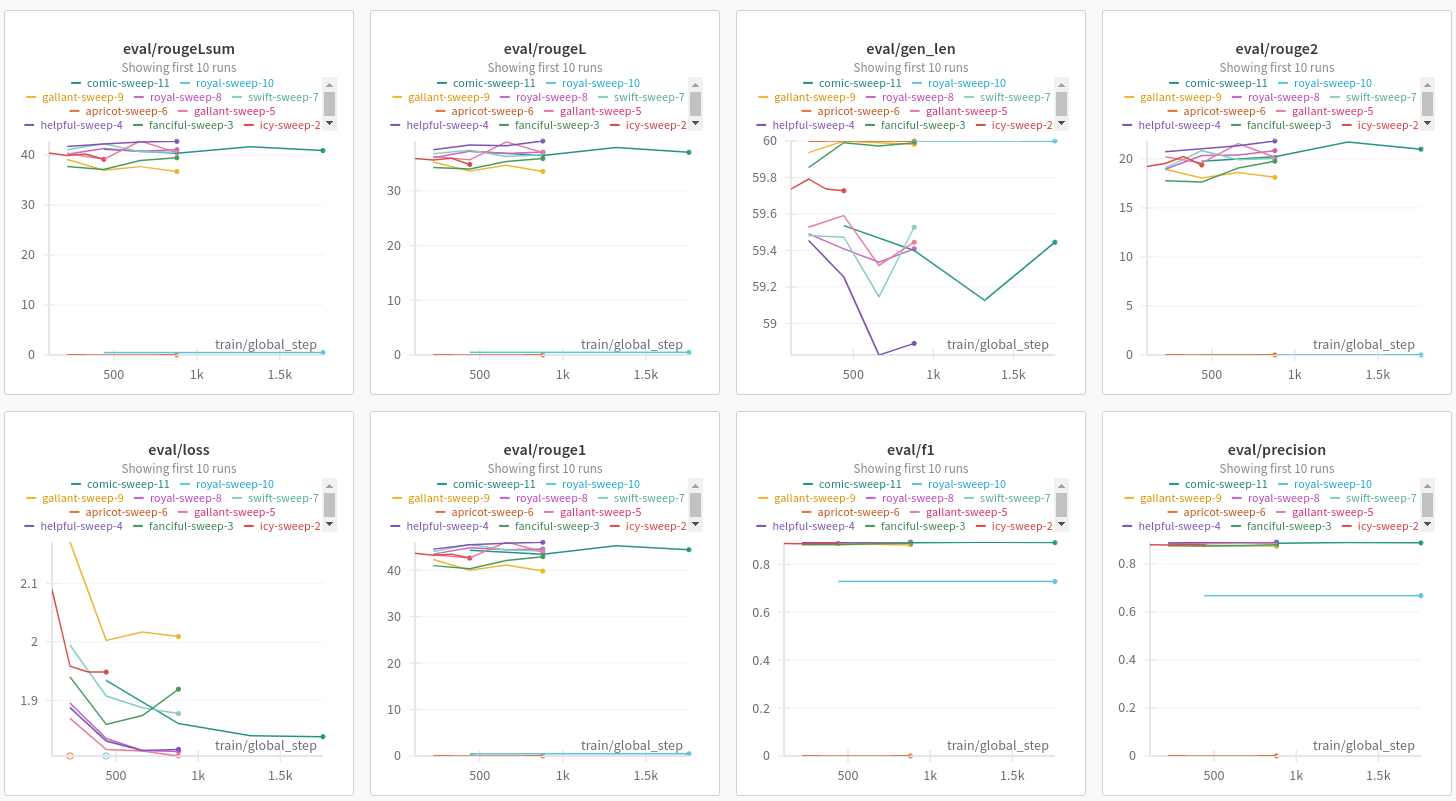

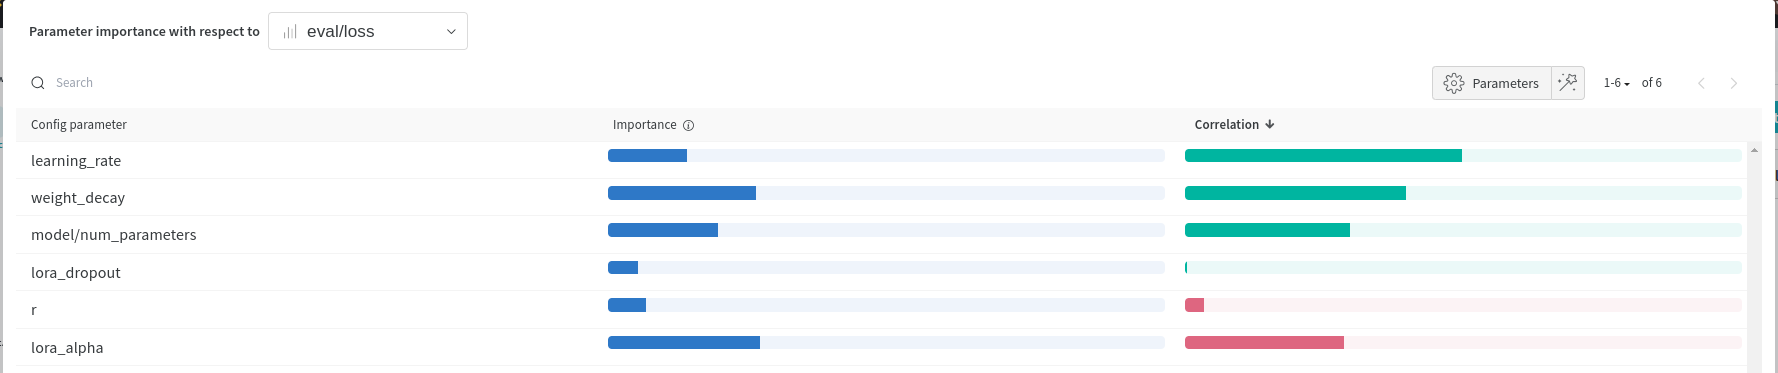

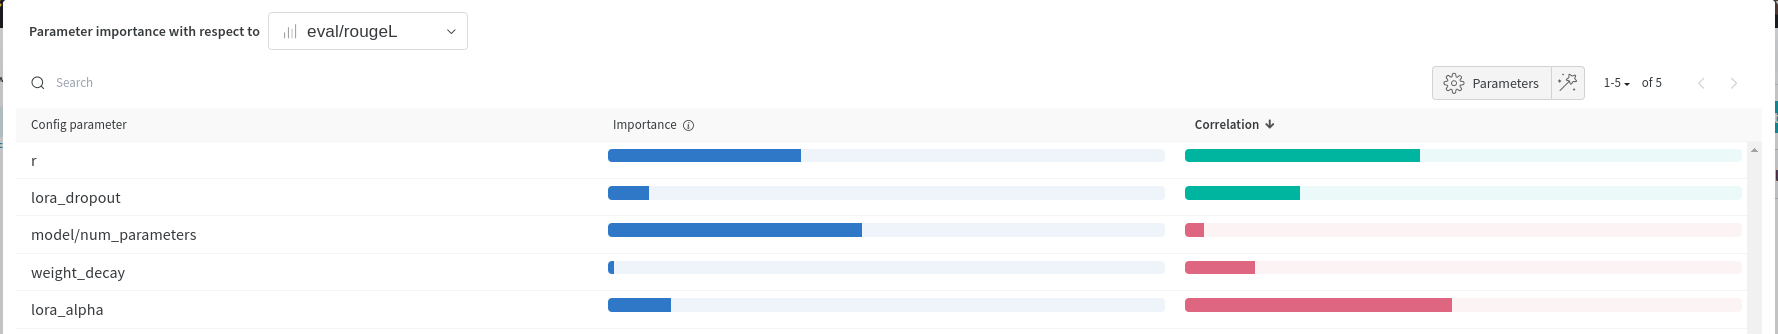

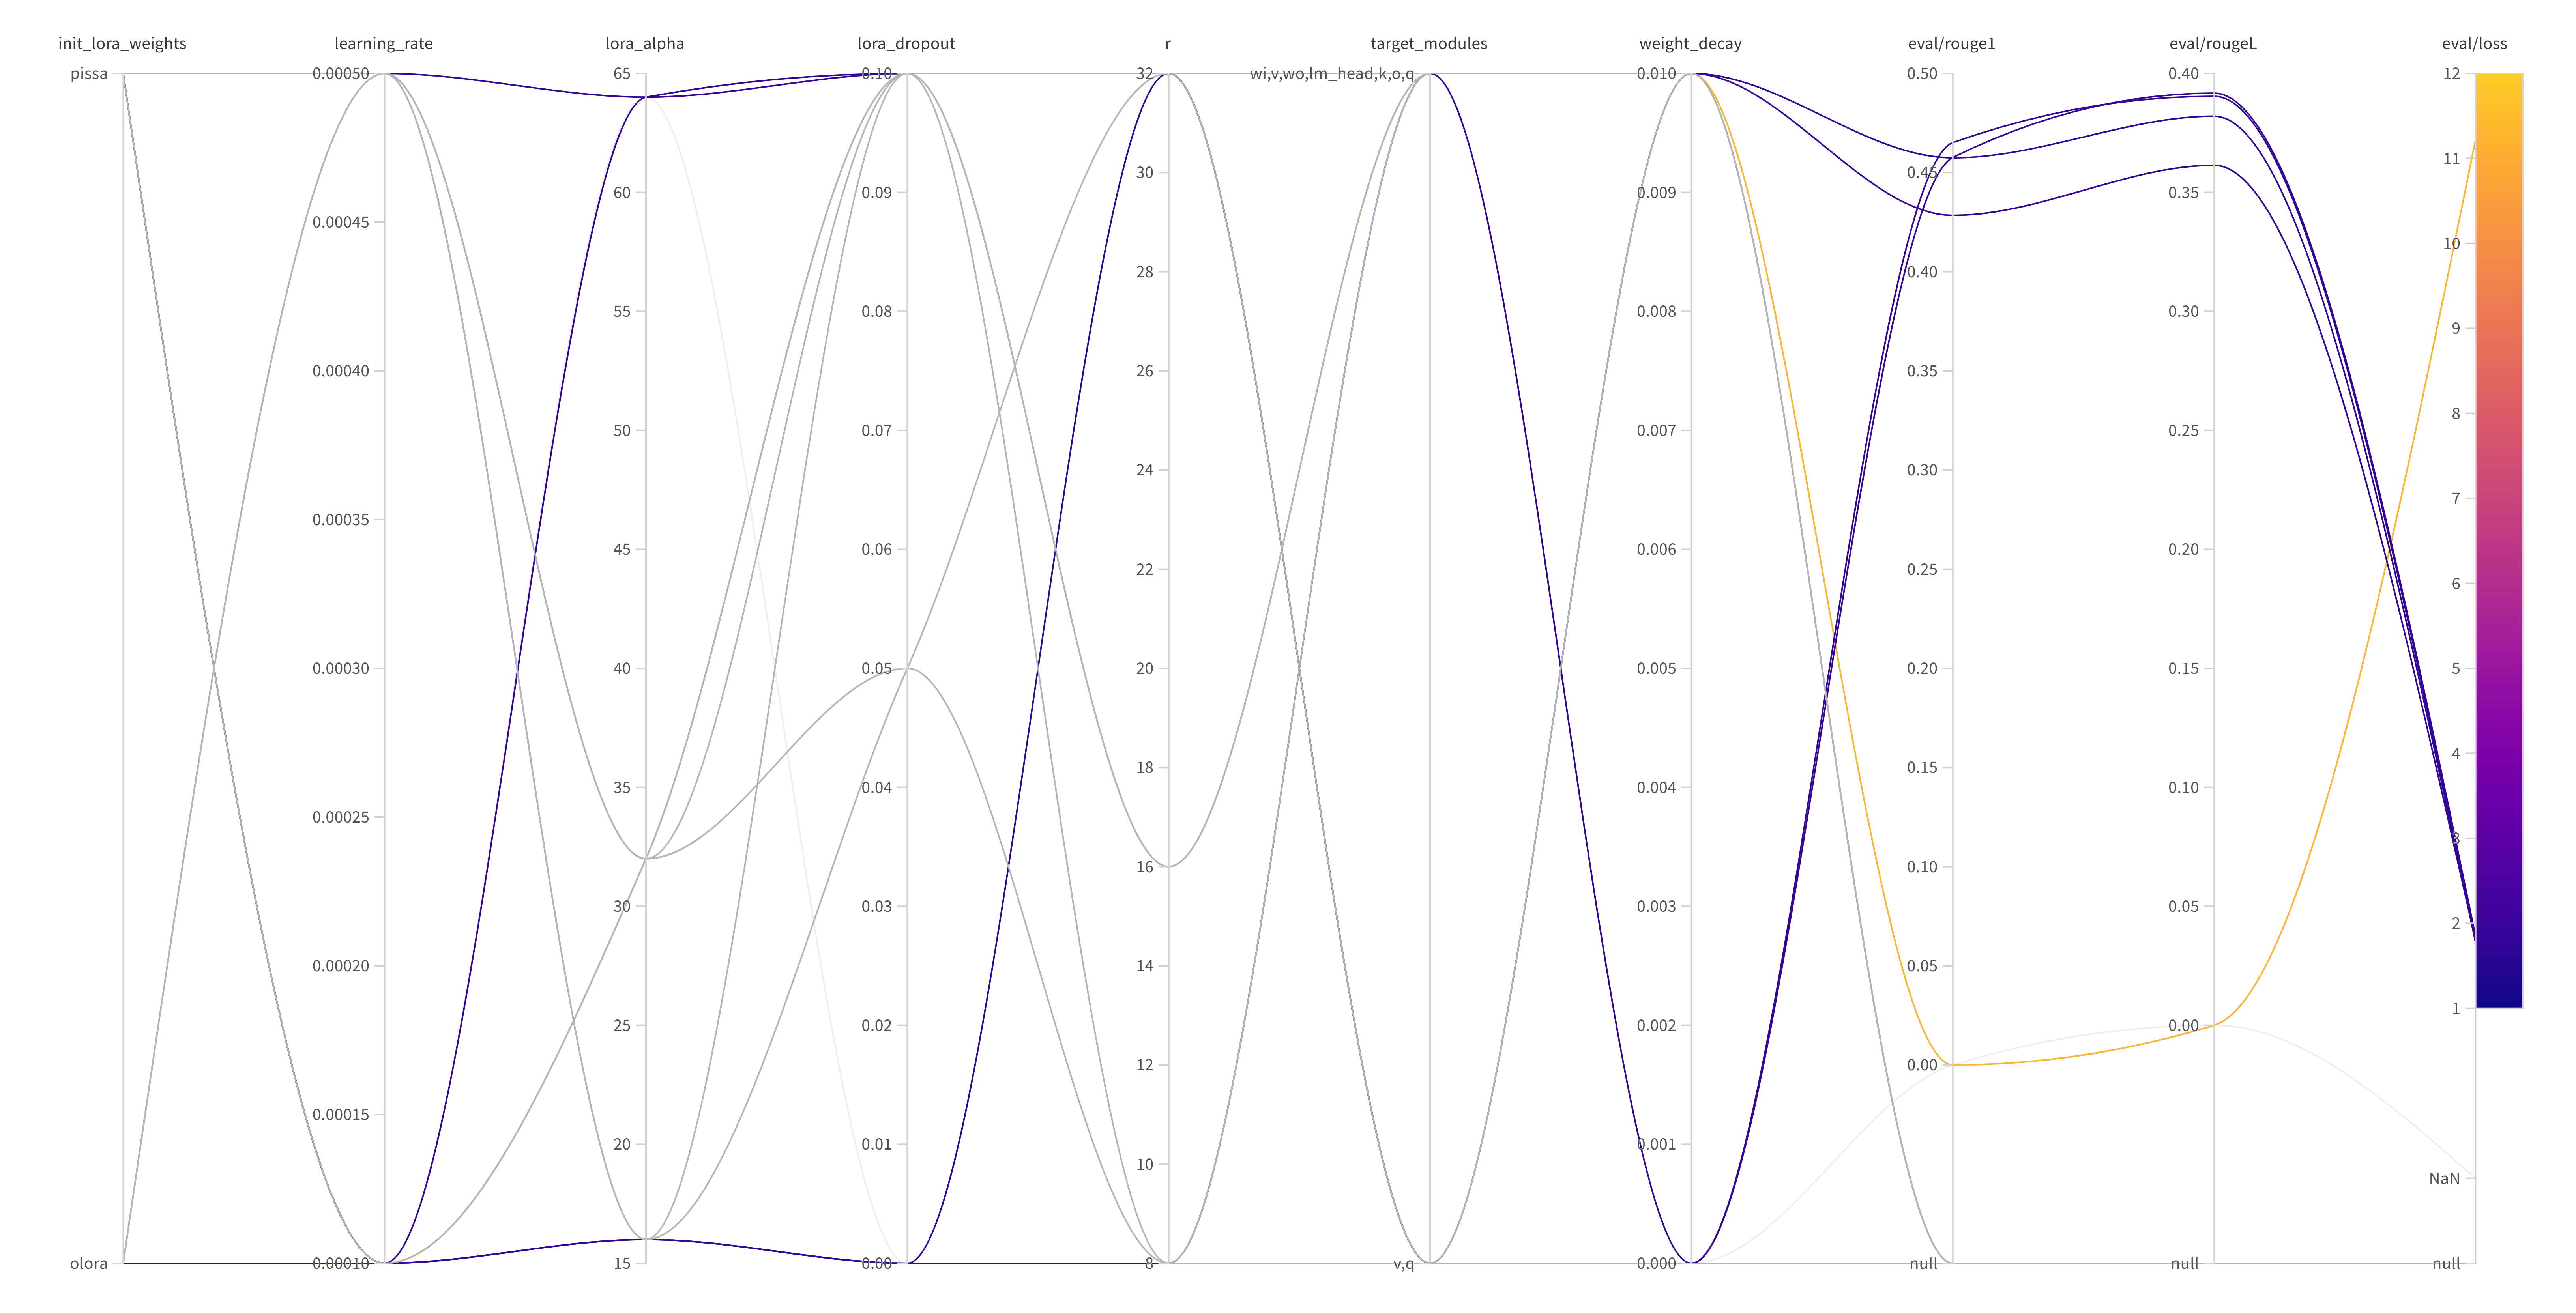

**W&B Report**

- t5-base: https://api.wandb.ai/links/samuel-lima-tech4humans/c6s2wzfi
- t5-small: https://api.wandb.ai/links/samuel-lima-tech4humans/e19onuv9

Here I will load the model that achieved the best results for inference

In [ ]:
lora_model_name = f"{model_id.split('/')[1]}-lora-finetune-tweetsumm"

In [ ]:
model_base = AutoModelForSeq2SeqLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

lora_peft_model = PeftModel.from_pretrained(model_base,
                                       f"samuellimabraz/{lora_model_name}",
                                       is_trainable=False)

adapter_config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:923: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/155M [00:00<?, ?B/s]

In [ ]:
lora_peft_model.to(device)
lora_peft_model.device

device(type='cuda', index=0)

In [ ]:
models[lora_model_name] = lora_peft_model

##### QLoRA

QLoRA (Quantized Low-Rank Adaptation) combines the traditional quantization technique with LoRA to improve fine-tuning efficiency.

It was introduced by Dettmers et al. in May 2023 (QLoRA Paper), and they demonstrated that QLoRA could fine-tune a 65B parameter model with a single 48GB GPU, preserving the full performance of 16-bit fine-tuning tasks.

![QLoRA illustration](https://miro.medium.com/v2/resize:fit:1400/1*e2xnfI4zDhih3U8bOBNacg.png)

It presents some innovations without reducing performance:

- 4-bit Normal Float (NF4), a new data type that is theoretically ideal information for normally distributed weights, which occupies half a byte per element.
- Double quantization to reduce average memory consumption by quantizing the quantization constants, using the Hugging Face bitsandbytes implementation.
- Paged optimizers to manage memory spikes.

###### Training

Here we define the configuration parameters for the sweep. For QLoRA, the parameters will be very similar to those used and explained previously in LoRA.

A relevant difference is that we will not use PiSSA and OLoRA initializations, as there is greater complexity in using them with the quantized model.

In [ ]:
# Define the sweep configuration
qlora_sweep_configuration = {
    'method': 'random',
    'parameters': {
        'learning_rate': {'values': [5e-4, 1e-4, 2e-5]},
        'weight_decay' : {'values': [0.01, 0.0]},
        'r': {'values': [8, 16, 32]},
        'lora_alpha': {'values': [16, 32, 64]},
        'target_modules' : {'values': [['v', 'q'], ['wi', 'v', 'wo', 'lm_head', 'k', 'o', 'q']]},
        'lora_dropout': {'values': [0.0, 0.05, 0.1]},
    }
}

In [ ]:
class QLoRAFinetuner(BaseTuner):
    def load_quantized_model(self):
        """Carrega o modelo quantizado usando configuração de 4 bits."""
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )
        quant_model = AutoModelForSeq2SeqLM.from_pretrained(
            self.model_id,
            quantization_config=quant_config,
        )
        return prepare_model_for_kbit_training(quant_model)


    def setup_model(self, config):
        """Configura o modelo LoRA com quantização usando os hiperparâmetros do config."""
        quant_model = self.load_quantized_model()
        qlora_config = LoraConfig(
            r=config.r,
            lora_alpha=config.lora_alpha,
            lora_dropout=config.lora_dropout,
            target_modules=config.target_modules,
            inference_mode=False,
            task_type=TaskType.SEQ_2_SEQ_LM,
            use_rslora=True,
        )
        qlora_model =  get_peft_model(quant_model, qlora_config)
        qlora_model.config.use_cache = False
        return qlora_model

    def setup_training_args(self, config):
        return Seq2SeqTrainingArguments(
            **self.common_training_args(config.repository_id),
            learning_rate=config.learning_rate,
            weight_decay=config.weight_decay,
            num_train_epochs=config.num_train_epochs,
            warmup_steps=2,
            optim="paged_adamw_8bit"
        )

In [ ]:
qlora_model_name= f"{model_id.split('/')[1]}-qlora-finetune-tweetsumm"

In [ ]:
qlora_finetuner = QLoRAFinetuner(model_id, tokenizer, train_dataset, eval_dataset, compute_metrics)
qlora_wandb_sweeper = WandbSweeperTuner(qlora_finetuner, qlora_sweep_configuration, project_name=qlora_model_name)
qlora_wandb_sweeper.start_sweep(count=11)

Create sweep with ID: yqt40l98
Sweep URL: https://wandb.ai/michwirja-galvatron/t5-base-qlora-finetune-tweetsumm/sweeps/yqt40l98


wandb: Agent Starting Run: slde7qor with config:
wandb: 	learning_rate: 2e-05
wandb: 	lora_alpha: 16
wandb: 	lora_dropout: 0.05
wandb: 	r: 8
wandb: 	target_modules: ['wi', 'v', 'wo', 'lm_head', 'k', 'o', 'q']
wandb: 	weight_decay: 0


/tmp/ipython-input-3743437627.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  return Seq2SeqTrainer(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:280: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:280: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to

trainable model parameters: 3,507,200
all model parameters: 155,631,872
percentage of trainable model parameters: 2.25%
***** train metrics *****
  all_params               =  155631872
  epoch                    =        3.0
  memory_footprint         =  410190848
  total_flos               =  2354341GF
  train_loss               =     2.9931
  train_runtime            = 0:13:25.68
  train_samples_per_second =      3.273
  train_steps_per_second   =       0.41
  trainable_params         =    3507200
  trainable_params_percent =     2.2535


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 402, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 403 Client Error: Forbidden for url: https://huggingface.co/api/repos/create

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-3137182131.py", line 12, in train_with_wandb
    self.finetuner.train(config)
  File "/tmp/ipython-input-3743437627.py", line 84, in train
    self.save_model(trainer, train_result)
  File "/tmp/ipython-input-3743437627.py", line 46, in save_model
    trainer.push_to_hub(**kwargs)
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 5154, in push_to_hub
    self.init_hf_repo(token=token)
  File "/u

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 402, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 403 Client Error: Forbidden for url: https://huggingface.co/api/repos/create

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 296, in _run_job
    self._function()
  File "/tmp/ipython-input-3137182131.py", line 12, in train_with_wandb
    self.finetuner.train(config)
  File "/tmp/ipython-input-3743437627.py", line 84, in train
    self.save_model(trainer, train_result)
  File "/tmp/ipython-input-3743437627.py", line 46, in save_model
    trainer.push_to_hub(**kwargs)
  File "/usr/local/lib/pytho

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:923: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(
/tmp/ipython-input-3743437627.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  return Seq2SeqTrainer(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentran

/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:280: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/peft/utils/save_and_load.py:280: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to

trainable model parameters: 3,507,200
all model parameters: 155,631,872
percentage of trainable model parameters: 2.25%
***** train metrics *****
  all_params               =  155631872
  epoch                    =        3.0
  memory_footprint         =  410190848
  total_flos               =  2354341GF
  train_loss               =     2.0787
  train_runtime            = 0:12:52.81
  train_samples_per_second =      3.412
  train_steps_per_second   =      0.427
  trainable_params         =    3507200
  trainable_params_percent =     2.2535


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 402, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 403 Client Error: Forbidden for url: https://huggingface.co/api/repos/create

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipython-input-3137182131.py", line 12, in train_with_wandb
    self.finetuner.train(config)
  File "/tmp/ipython-input-3743437627.py", line 84, in train
    self.save_model(trainer, train_result)
  File "/tmp/ipython-input-3743437627.py", line 46, in save_model
    trainer.push_to_hub(**kwargs)
  File "/usr/local/lib/python3.12/dist-packages/transformers/trainer.py", line 5154, in push_to_hub
    self.init_hf_repo(token=token)
  File "/u

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_http.py", line 402, in hf_raise_for_status
    response.raise_for_status()
  File "/usr/local/lib/python3.12/dist-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 403 Client Error: Forbidden for url: https://huggingface.co/api/repos/create

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/wandb/agents/pyagent.py", line 296, in _run_job
    self._function()
  File "/tmp/ipython-input-3137182131.py", line 12, in train_with_wandb
    self.finetuner.train(config)
  File "/tmp/ipython-input-3743437627.py", line 84, in train
    self.save_model(trainer, train_result)
  File "/tmp/ipython-input-3743437627.py", line 46, in save_model
    trainer.push_to_hub(**kwargs)
  File "/usr/local/lib/pytho

/tmp/ipython-input-3743437627.py:63: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  return Seq2SeqTrainer(
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'weight_decay' was locked by 'sweep' (ignored update).
/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1044: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


In [ ]:
wandb.finish()

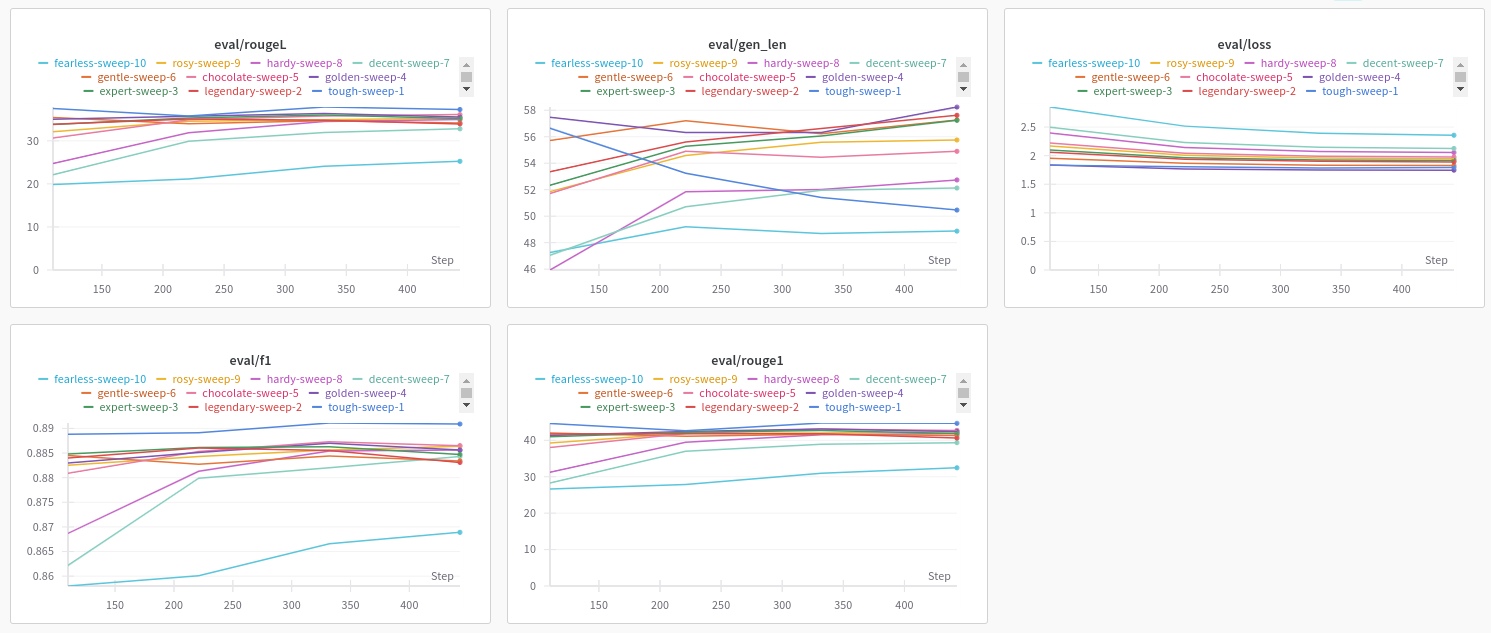

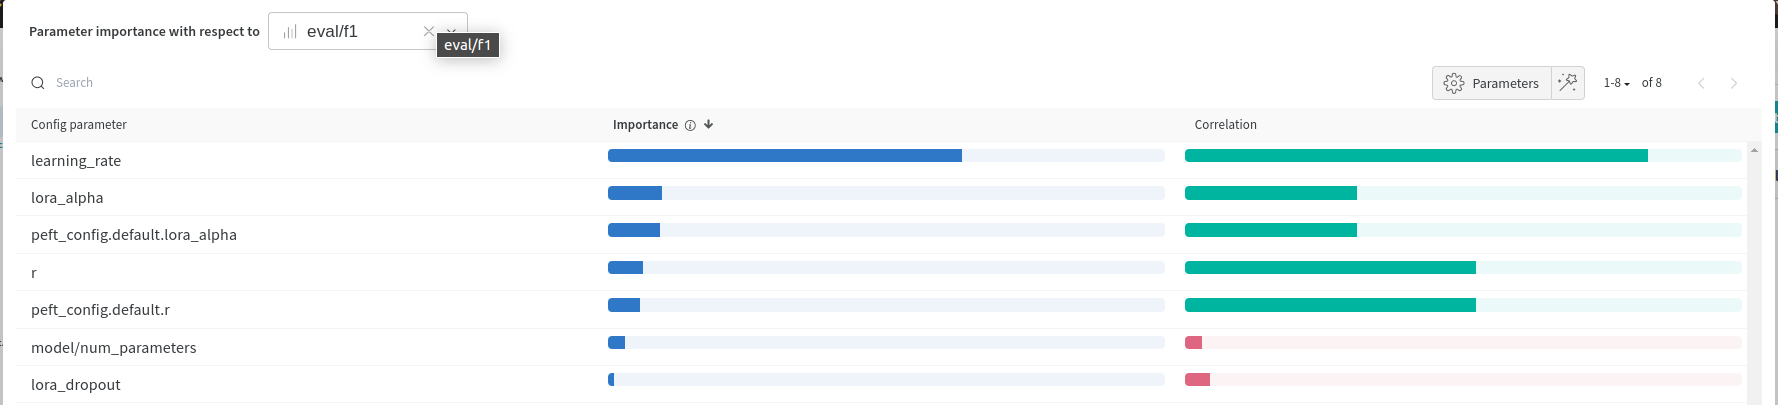

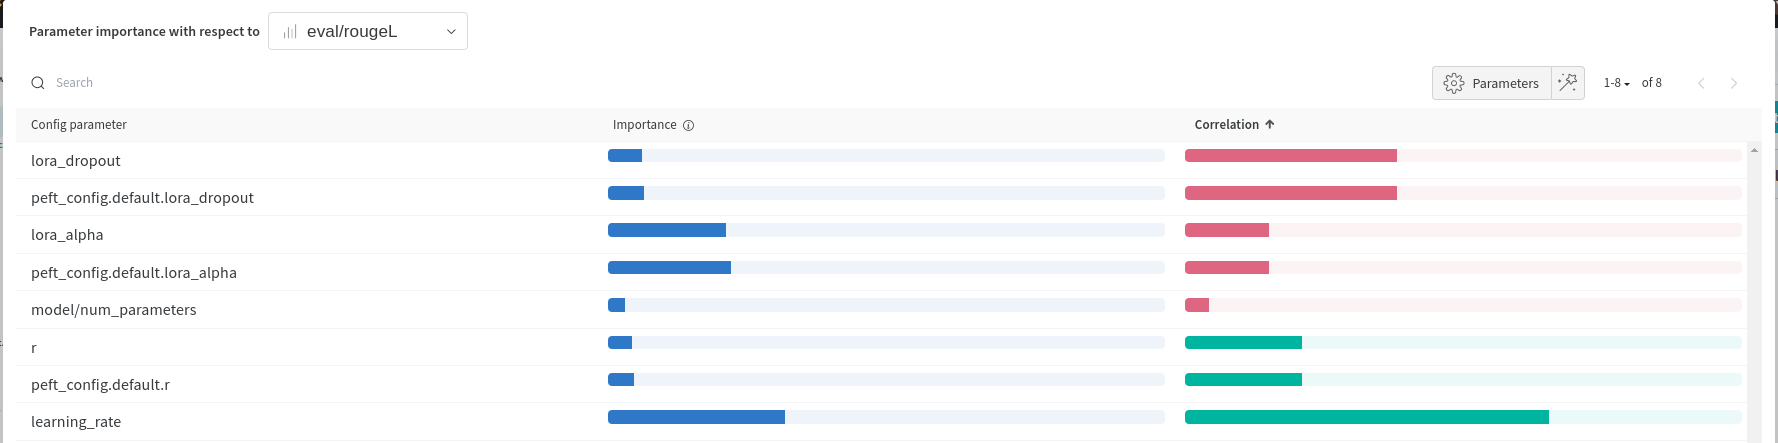

**W&B Report**

- t5-base: https://api.wandb.ai/links/samuel-lima-tech4humans/at5r9zle
- t5-small: https://api.wandb.ai/links/samuel-lima-tech4humans/m3um8d8c

Loading the best model from the hub for inference

In [ ]:
qlora_peft_model = AutoPeftModelForSeq2SeqLM.from_pretrained(f"samuellimabraz/{qlora_model_name}", is_trainable=False)

In [ ]:
qlora_peft_model.merge_and_unload()

In [ ]:
qlora_peft_model.to(device)
qlora_peft_model.device

In [ ]:
models[qlora_model_name] = qlora_peft_model

##### **IA3**

![IA3](https://pic3.zhimg.com/v2-16245cbb097054ca4f89d1da288c2a4a_r.jpg)

(IA)³ (Infused Adapter by Inhibiting and Amplifying Inner Activations) modifies only specific learned vectors associated with the key, value, and feedforward layers within transformer blocks.

The method introduces three vectors, `lv`, `lk`, and `lf`, which rescale activations in the attention and feedforward layers. This approach keeps most of the model's weights frozen, drastically reducing the number of trainable parameters.



In [ ]:
ia3_sweep_configuration = {
    'method': 'random',
    'parameters': {
        'learning_rate': {'values': [5e-4, 1e-4, 1e-5, 1e-3]},
        'weight_decay' : {'values': [0.01, 0.0]},
        'target_modules' : {'values': [['v', 'q'], ['wi', 'v', 'wo', 'lm_head', 'k', 'o', 'q']]},
    }
}

In [ ]:
class IA3Finetuner(BaseTuner):
    def setup_model(self, config):
        base_model = AutoModelForSeq2SeqLM.from_pretrained(self.model_id)
        ia3_config = IA3Config(
          task_type="SEQ_2_SEQ_LM",
          target_modules=config.target_modules
        )
        return get_peft_model(base_model, ia3_config)

In [ ]:
ia3_model_name = f"{model_id.split('/')[1]}-ia3-finetune-tweetsumm"

In [ ]:
ia3_finetuner = IA3Finetuner(model_id, tokenizer, train_dataset, eval_dataset, compute_metrics)
ia3_wandb_sweeper = WandbSweeperTuner(ia3_finetuner, ia3_sweep_configuration, project_name=ia3_model_name)
ia3_wandb_sweeper.start_sweep(count=10, epochs=5)

In [ ]:
wandb.finish()


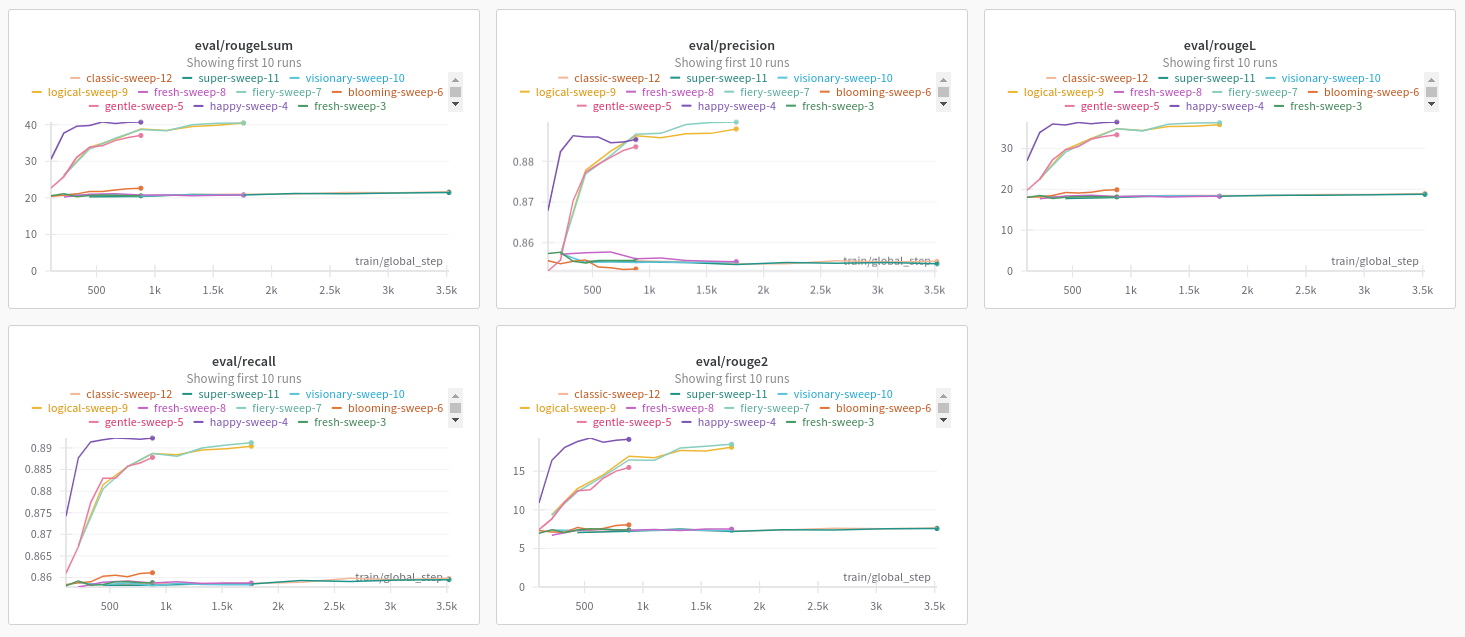

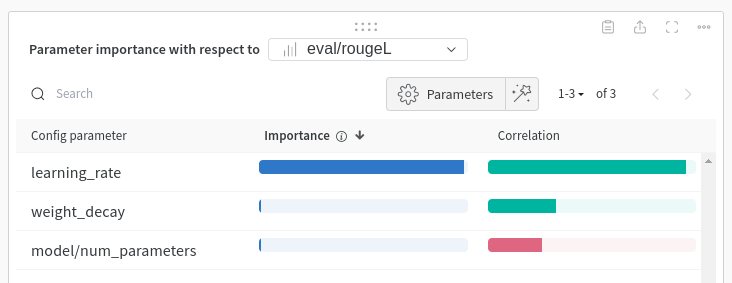

**W&B Report**

- t5-base: https://api.wandb.ai/links/samuel-lima-tech4humans/1nthw7ac
- t5-small: https://api.wandb.ai/links/samuel-lima-tech4humans/miafp4j2

In [ ]:
peft_model_base = AutoModelForSeq2SeqLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
ia3_model = PeftModel.from_pretrained(peft_model_base,
                                       f"samuellimabraz/{ia3_model_name}",
                                       is_trainable=False)

In [ ]:
ia3_model.to(device)
ia3_model.device

In [ ]:
models[ia3_model_name] = ia3_model

### Final Analysis

#### Analysis Qualitative

In [ ]:
qualitative_evaluation(models, dataset)

#### Analysis Quantitative

In [ ]:
df_metrics, styled_df_metrics = build_metrics_dataframe(dialogues, human_baseline_summaries, models, tokenizer)

In [ ]:
display(styled_df_metrics)

In [ ]:
percent_diff_tables = compare_models_percentage(df_metrics)
# Acessar e exibir a tabela de comparação percentual para um modelo específico
percent_diff_tables['t5-base']

In [ ]:
percent_diff_tables[full_fine_tune]

In [ ]:
df_metrics.to_csv(f"{model_id.split('/')[1]}-results.csv", encoding='utf-8', header=True)

## References

### Articles

* [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - Vladislav Lialin, Vijeta Deshpande, Anna Rumshisky, 2023.

* [LoRA: Low-Rank Adaptation of Large Language Models](https://arxiv.org/abs/2106.09685) - Edward J. Hu, Yelong Shen, Phillip Wallis, Zeyuan Allen-Zhu, Yuanzhi Li, Shean Wang, Lu Wang, Weizhu Chen, 2021.

* [Intrinsic Dimensionality Explains the Effectiveness of Language Model Fine-Tuning](https://arxiv.org/abs/2012.13255) - Armen Aghajanyan, Luke Zettlemoyer, Sonal Gupta

* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) - Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin, 2023

* [A Rank Stabilization Scaling Factor for Fine-Tuning with LoRA](https://arxiv.org/abs/2312.03732) - Damjan Kalajdzievski, 2023.

### Webpages

- [PEFT (Parameter-Efficient Fine-Tuning)](https://huggingface.co/docs/peft/index) - Hugging Face. Accessed 22 August 2024.

- [Finetune LLMs on your own consumer hardware using tools from PyTorch and Hugging Face ecosystem](https://pytorch.org/blog/finetune-llms/) - PyTorch. Accessed 28 August 2024.

- [Fine-tuning | How-to guides](https://llama.meta.com/docs/how-to-guides/fine-tuning/) - Llama, Accessed 22 August 2024.

- [Transformers pytorch examples | Summarization](https://github.com/huggingface/transformers/tree/main/examples/pytorch/summarization)

- [How to evaluate a summarization task - Shyamal Anadkat, Simón Fishman](https://cookbook.openai.com/examples/evaluation/how_to_eval_abstractive_summarization)

- [Mastering ROUGE Matrix: Your Guide to Large Language Model Evaluation for Summarization with Examples](https://dev.to/aws-builders/mastering-rouge-matrix-your-guide-to-large-language-model-evaluation-for-summarization-with-examples-jjg)

- [How do Transformers work? - Hugging Face NLP Course](https://huggingface.co/learn/nlp-course/pt/chapter1/4)

- [Finetuning Transformer Models - Codecademy](https://www.codecademy.com/enrolled/courses/finetuning-transformer-models)


